**This File**

This file is aimed to contain code used to generate any figures used in the final paper, so that all styles can be updated simultaneously. This file should be kept clean with only plot creation code and no data generation so that the whole file may be run to generate all plots in a timely manner.

In [2]:
%run gradients
%run representation_analysis
%run read_experiments
%run trajectories

from scipy import stats

pplt.rc.reset()

def add_abc_to_subaxes(ax, text='A.', left=0, top=1.05):
    '''
    Add ABC type labels to specific subaxes similar to those
    from proplot
    
    Note that if creating a single ax as in fig, ax = pplt.subplots()
    the ax to pass in is add_abc_to_subaxes(ax[0]) since it works
    with subaxes specifically
    '''
    abc_kw = pplt.rc.fill(
        {
            'size': 'abc.size',
            'weight': 'abc.weight',
            'color': 'abc.color',
            'family': 'font.family',
        },
        context=True
    )
    border_kw = pplt.rc.fill(
        {
            'border': 'abc.border',
            'borderwidth': 'abc.borderwidth',
            'bbox': 'abc.bbox',
            'bboxpad': 'abc.bboxpad',
            'bboxcolor': 'abc.bboxcolor',
            'bboxstyle': 'abc.bboxstyle',
            'bboxalpha': 'abc.bboxalpha',
        },
        context=True,
    )
    kw = {'zorder': 3.5, 'transform': ax.transAxes}
    
    ax.text(left, top, text, **abc_kw, **border_kw, **kw)



# Batch Size Effects

Plot demonstrating how batch size effects learning curves

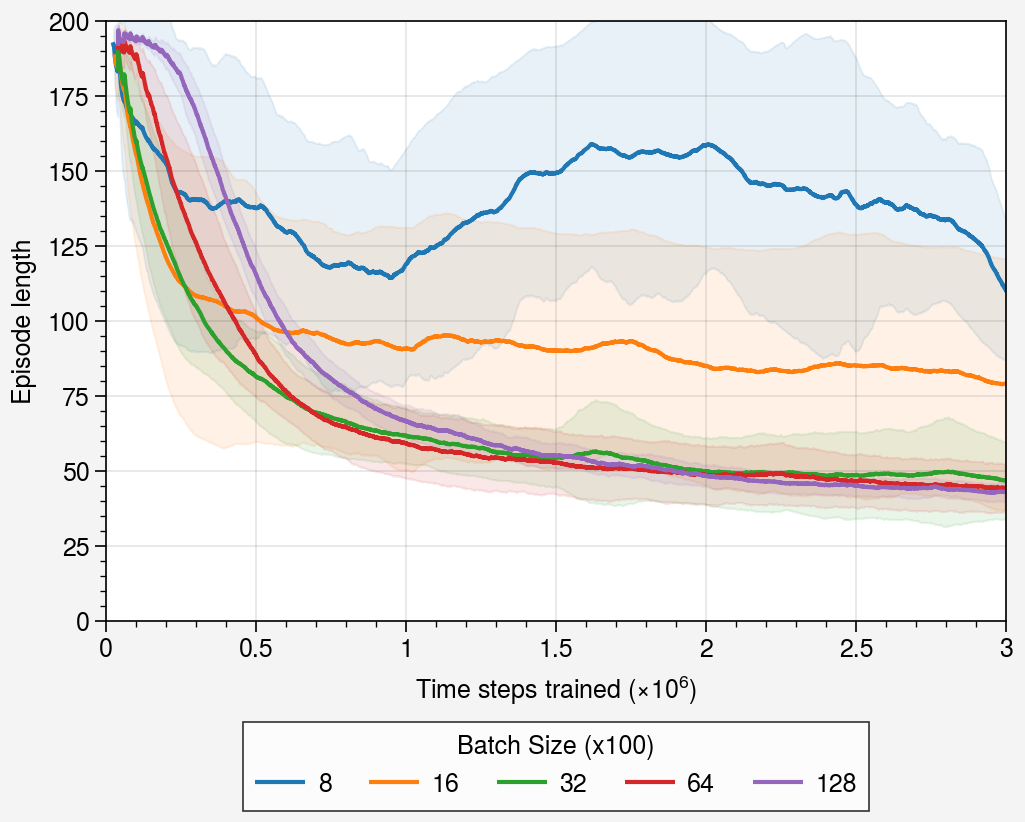

In [109]:
folder = 'nav_pdistal_batchaux'
batch_sizes = [8, 16, 32, 64, 128]
fig, ax = pplt.subplots(refheight=3, refaspect=1.5)

hs = []
for i, batch in enumerate(batch_sizes):
    exp = f'{folder}/nav_pdistal_batch{batch}auxnone'
    h = average_runs(exp, 'length', ax=ax, label=f'Batch {batch}', cloud_by='std', 
                     ignore_first=100, color=rgb_colors[i], ewm=0.001, div_x_by_mil=True)
    hs.append(h)
    
fig.legend(hs, loc='b', labels=[f'{batch}' for batch in batch_sizes], title='Batch Size (x100)', ncol=5)
ax.format(xlabel=r'Time steps trained ($\times 10^6$)', ylabel='Episode length', ylim=[0, 200],
         xlim=[0, 3])

plt.savefig('plots/paper/1_batchsize_effects')

## Network Width Effects

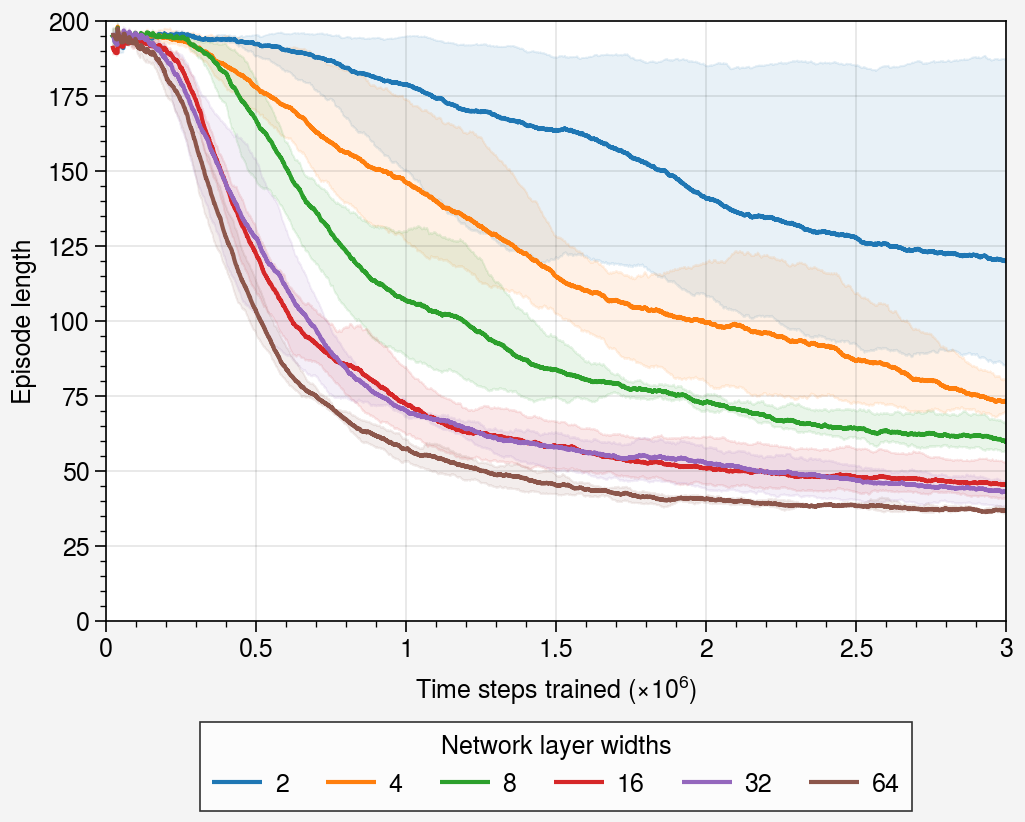

In [108]:
widths = [2, 4, 8, 16, 32, 64]
distal_exp_names = [f'nav_poster_netstructure/nav_pdistal_width{width}batch200' for width in widths]
fig, ax = pplt.subplots(refheight=3, refaspect=1.5)

lines = []
for i in range(len(widths)):
    line = average_runs(distal_exp_names[i], 'length', ax=ax, ignore_first=100, ewm=0.001,
                 div_x_by_mil=True, color=rgb_colors[i])
    lines.append(line[0])
    
ax.format(
    xlabel=r'Time steps trained ($\times 10^6$)', 
    ylabel='Episode length',
    # title='Training Curves for Different Network Widths on Poster Environments',
    ylim=[0, 200],
    xlim=[0, 3]
)
fig.legend(lines, title='Network layer widths', labels=[str(w) for w in widths], loc='b', ncol=len(widths))
plt.savefig('plots/paper/1_1_layerwidth_effects')

# Environment Demonstrations

**A: Example of environment. B: Cartoon depiction of network used by RL agent**

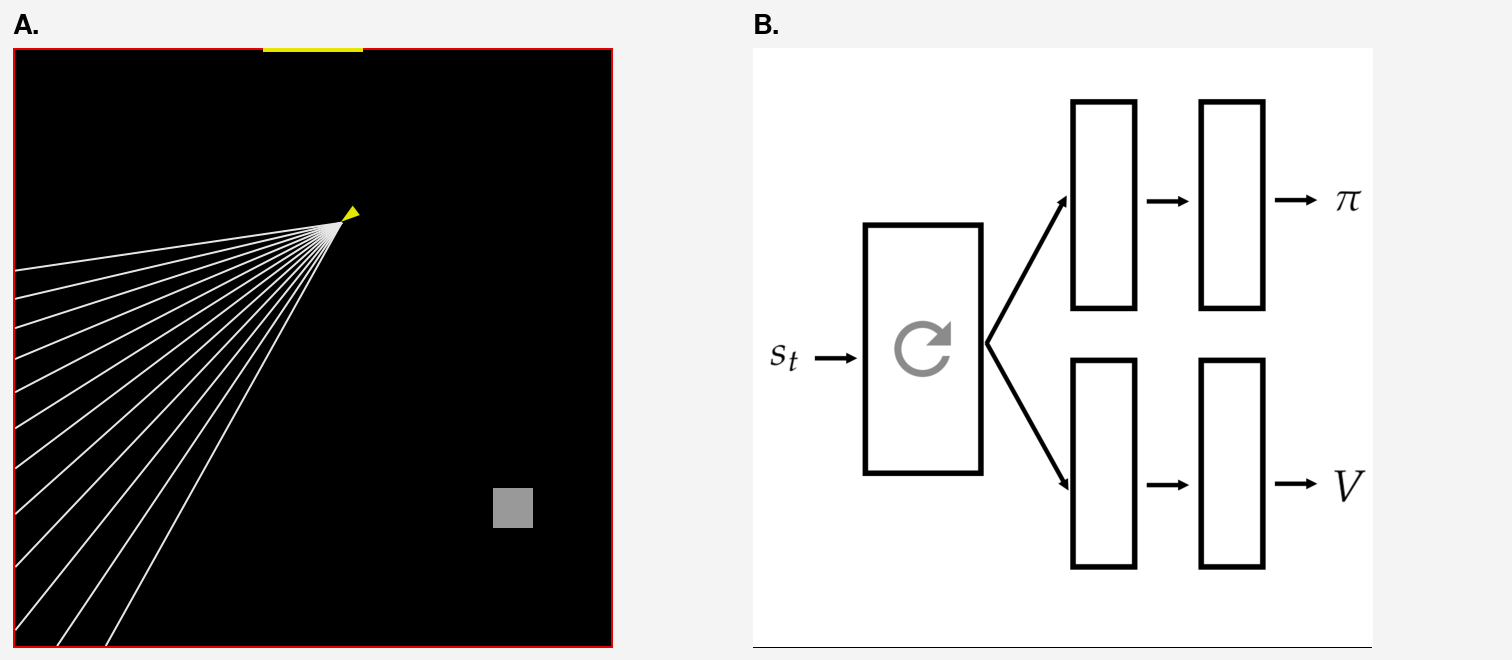

In [85]:
import matplotlib.image as mpimg

env_kwargs = pickle.load(open('../trained_models/ppo/nav_pdistal_batchaux/nav_pdistal_batch16auxnone_env', 'rb'))

pplt.rc.update({
    'axes.spines.bottom': False,
    'axes.spines.top': False,
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.facecolor': 'black',
    'axes.grid': False
})

fig, ax = pplt.subplots(ncols=2, wratios=(2, 3), refheight=3, sharex=False, sharey=False)

env = gym.make('NavEnv-v0', **env_kwargs)
np.random.seed(0)
env.reset()
env.render('human', ax=ax[0])

ax[1].imshow(mpimg.imread('plots/paper/nn_diagram.png'))
ax[0].format(xlim=[0, 300], ylim=[0, 300])
ax.format(abc='A.', abcloc='l')


fig.savefig('plots/paper/2_mwm_poster_env')

pplt.rc.reset()


# Auxiliary Task Performances

## Numerical Experiments

### Performance Significance

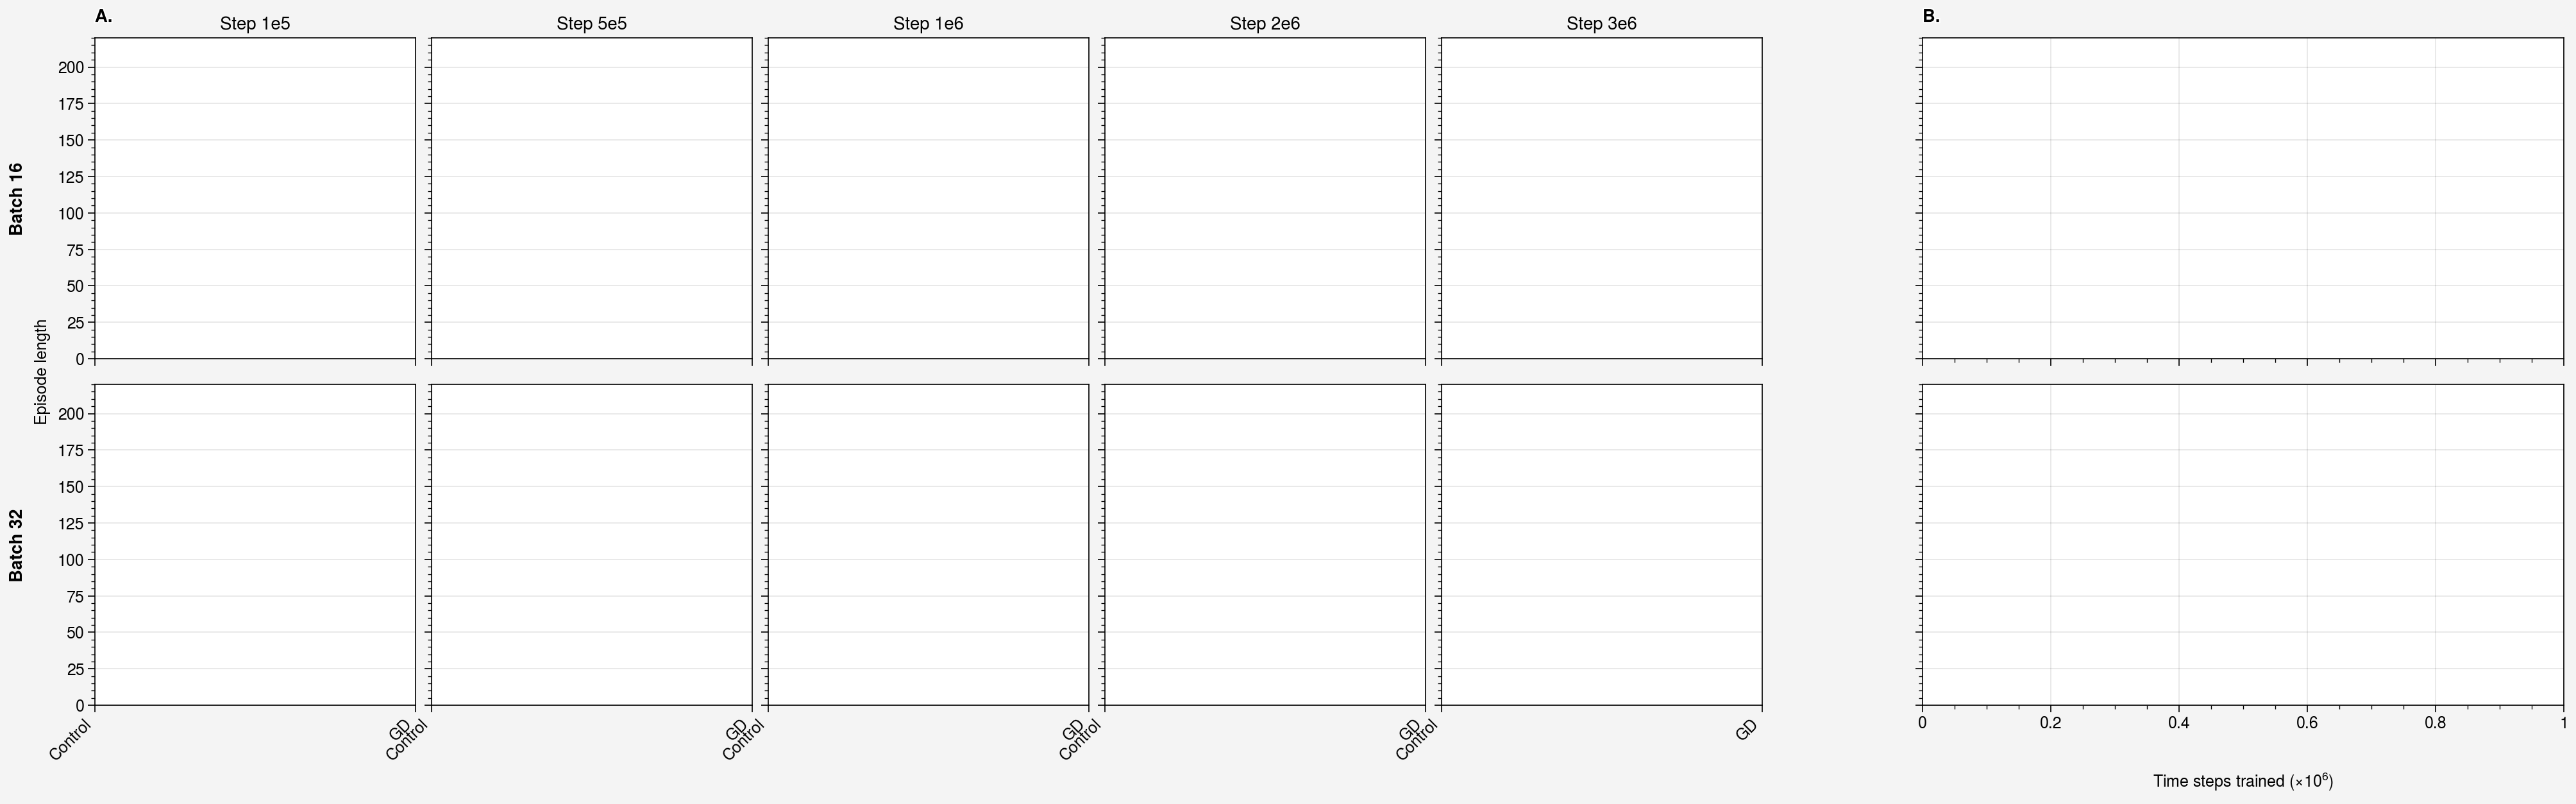

In [74]:
# Example formatting code

timepoint_labels = ['1e5', '5e5', '1e6', '2e6', '3e6']


fig, ax = pplt.subplots(nrows=2, ncols=6, 
                        wratios=(1, 1, 1, 1, 1, 2), wspace=(1, 1, 1, 1, 10),
                        spanx=1)

ax.format(ylim=[0, 200])
ax[:, :-1].format(xlocator=range(6))

add_abc_to_subaxes(ax[0, 0], 'A.')
add_abc_to_subaxes(ax[0, 5], 'B.')

ax[:, -1].format(xlabel=r'Time steps trained ($\times 10^6$)', ylabel='Episode length',
         ylim=[0, 220])
ax[0, :-1].format(title=[f'Step {step}' for step in timepoint_labels])
ax[:, :-1].format(xticklabels=aux_labels, xrotation=45,
          leftlabels=[f'Batch {batch}' for batch in batch_sizes],
          ylim=[0, 220])

**A: Performance at each slice of training. B: Overall learning curves, with lines showing where slices for A are taken**

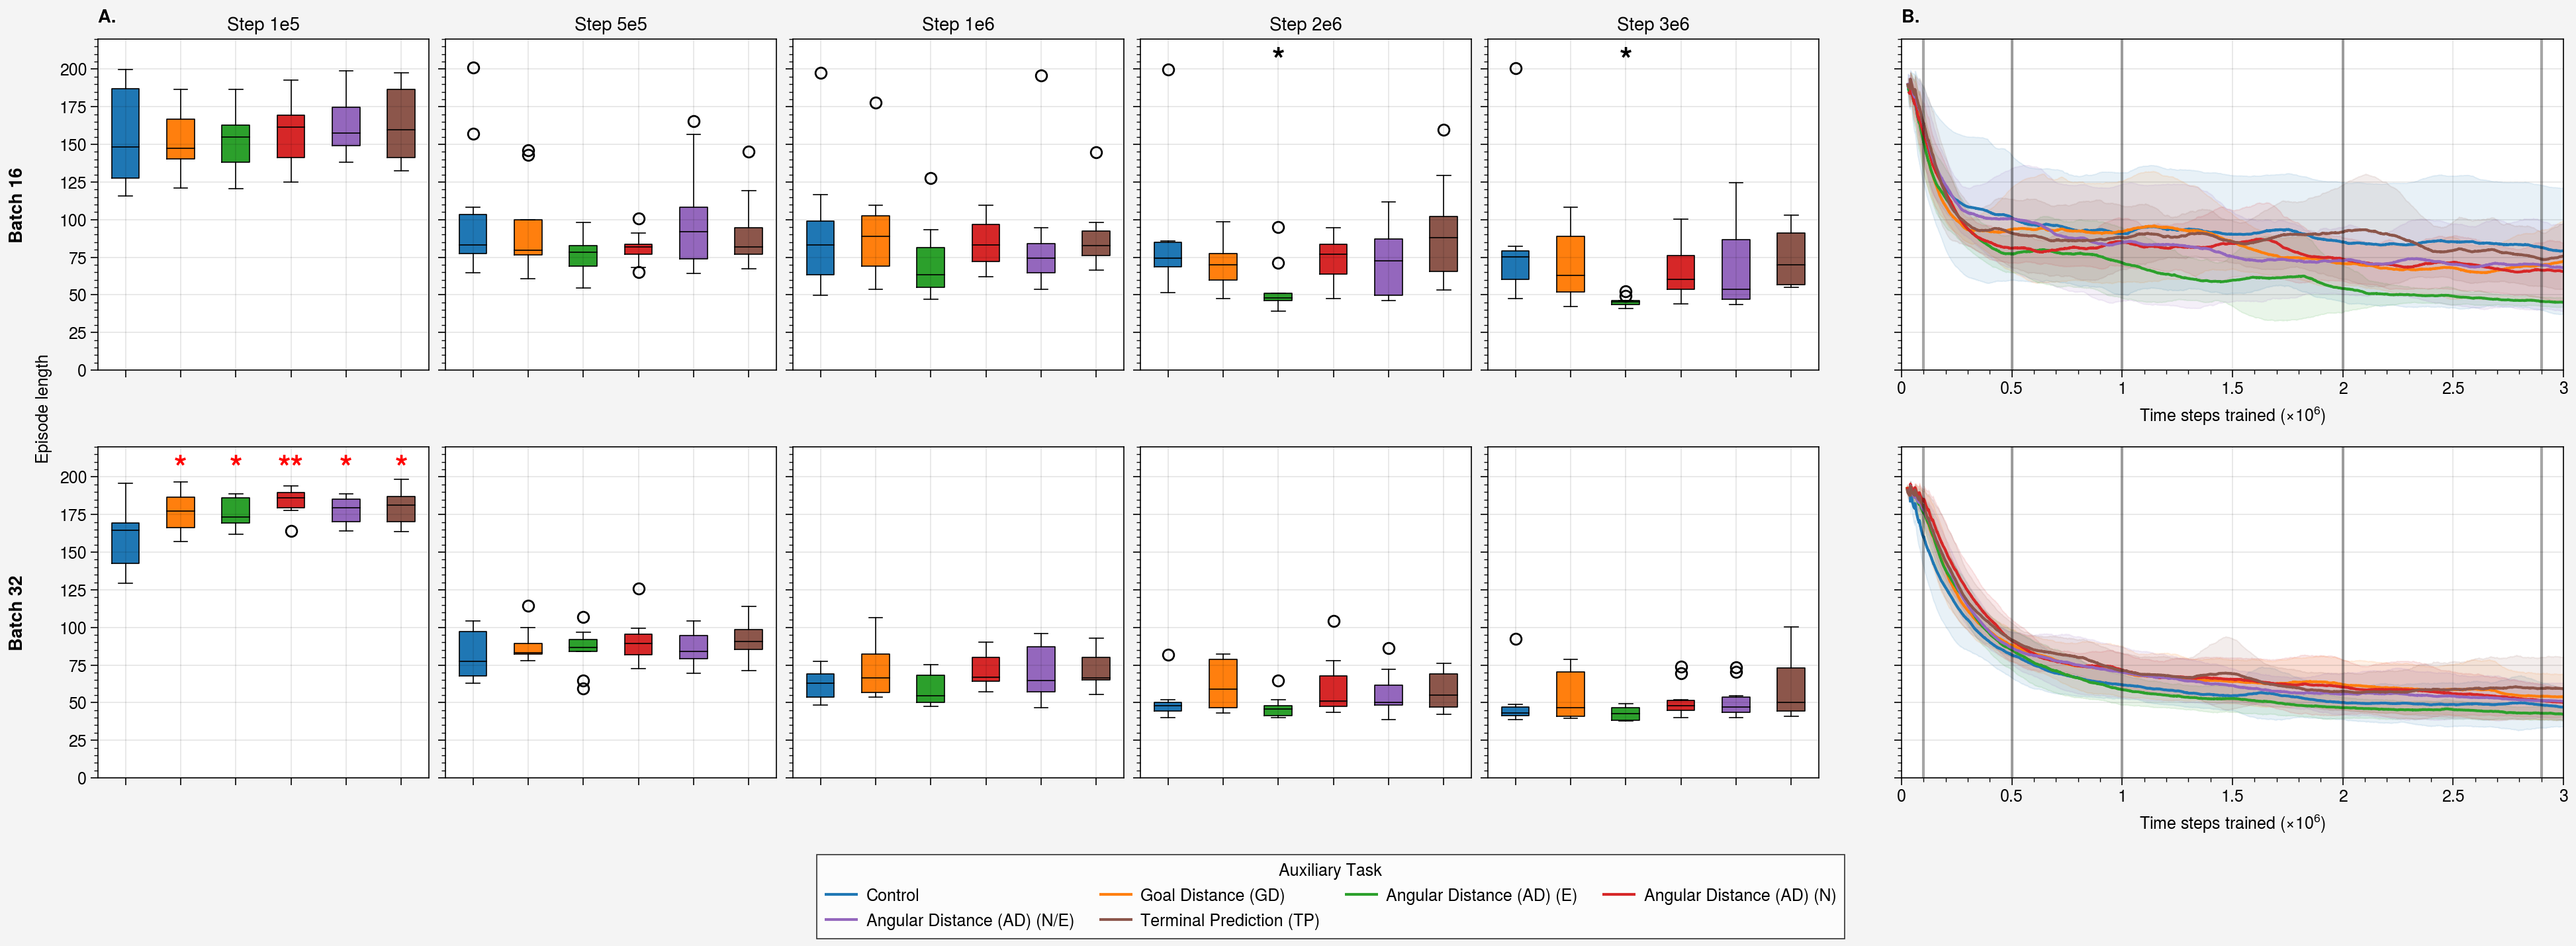

In [5]:
aux_tasks = ['none', 'goaldist', 'wall0', 'wall1', 'wall01', 'terminal']
aux_labels = ['Control', 'Goal Distance (GD)', 'Angular Distance (AD) (E)', 
              'Angular Distance (AD) (N)', 'Angular Distance (AD) (N/E)', 
              'Terminal Prediction (TP)']
batch_sizes = [16, 32]
timepoints = [100000, 500000, 1000000, 2000000, 2900000]
timepoint_labels = ['1e5', '5e5', '1e6', '2e6', '3e6']


fig, ax = pplt.subplots(nrows=len(batch_sizes), ncols=len(timepoints)+1, 
                        wratios=(1, 1, 1, 1, 1, 2), wspace=(1, 1, 1, 1, 5),
                        sharex=False)

# Collect time points data for making box plots
y_timepoints = {}
for i, batch in enumerate(batch_sizes):
    y_timepoints[batch] = defaultdict(list)
    
    for aux in aux_tasks:
        if aux == 'none':
            exp_name = f'nav_pdistal_batchaux/nav_pdistal_batch{batch}aux{aux}'
        else:
            exp_name = f'nav_pdistal_batchauxcoef1/nav_pdistal_batch{batch}aux{aux}coef1'
            
        xs, ys, start_x, start_y = average_runs(exp_name, 'length', ignore_first=100, ewm=0.001, ret=True)
        
        for n, timepoint in enumerate(timepoints):
            idx = np.argwhere(xs > timepoint)[0][0]
            y_timepoints[batch][timepoint].append(list(ys[:, idx]))

            
# Plot boxplots with significance stars

for i, batch in enumerate(batch_sizes):
    for j, timepoint in enumerate(timepoints):
        y_samples = y_timepoints[batch][timepoint]
        
        for n in range(1, 6):
            pvalue = stats.ttest_ind(y_samples[0], y_samples[n]).pvalue
            star = ''
            if pvalue < 0.05:
                star = '*'
            if pvalue < 0.01:
                star = '**'
            if pvalue < 0.001:
                star = '***'

            if np.mean(y_samples[0]) < np.mean(y_samples[n]):
                c = 'red'
            else:
                c = 'black'

            if len(star) > 0:
                ax[i, j].text(n, 215, star, c=c, ha='center', va='top', size=18, fontweight='bold')
        
        ax[i, j].boxplot(np.array(y_samples).T, fill=True,
          cycle=[list(rgb_colors[i]) for i in range(6)])
            


# Plot learning curves

for i, batch in enumerate(batch_sizes):
    lines = []
    for n, aux in enumerate(aux_tasks):
        if aux == 'none':
            exp_name = f'nav_pdistal_batchaux/nav_pdistal_batch{batch}aux{aux}'
        else:
            exp_name = f'nav_pdistal_batchauxcoef1/nav_pdistal_batch{batch}aux{aux}coef1'
            
        # exp_name = f'nav_pdistal_auxcat/nav_pdistal_width{width}aux{aux}'

        line = average_runs(exp_name, 'length', ax=ax[i, -1], ignore_first=100, ewm=0.001, color=rgb_colors[n],
                           cloud_by='std', div_x_by_mil=True)
        lines.append(line[0])

# Add time point lines to learning curves

timepoints = np.array([100000, 500000, 1000000, 2000000, 2900000])/1000000
for timepoint in timepoints:
    for i in range(2):
        ax[i, -1].plot([timepoint, timepoint], [-10, 230], 'black', alpha=0.35)
        
        

#Formatting 

add_abc_to_subaxes(ax[0, 0], 'A.')
add_abc_to_subaxes(ax[0, 5], 'B.')

ax[:, -1].format(xlabel=r'Time steps trained ($\times 10^6$)', ylabel='Episode length',
         ylim=[0, 220], xlim=[0, 3])
ax[0, :-1].format(title=[f'Step {step}' for step in timepoint_labels])

## Include x labels on box plots
# ax[:, :-1].format(xticklabels=aux_labels, xrotation=45,
#           leftlabels=[f'Batcch {batch}' for batch in batch_sizes],
#           ylim=[0, 220])
# No x labels for box plots
ax[:, :-1].format(leftlabels=[f'Batch {batch}' for batch in batch_sizes],
          ylim=[0, 220], xticklabels=[])

fig.legend(lines, loc='b', ncols=4, labels=aux_labels, 
           title='Auxiliary Task')

fig.savefig('plots/paper/3_1_1_numerical_learning_performance')


### Losses

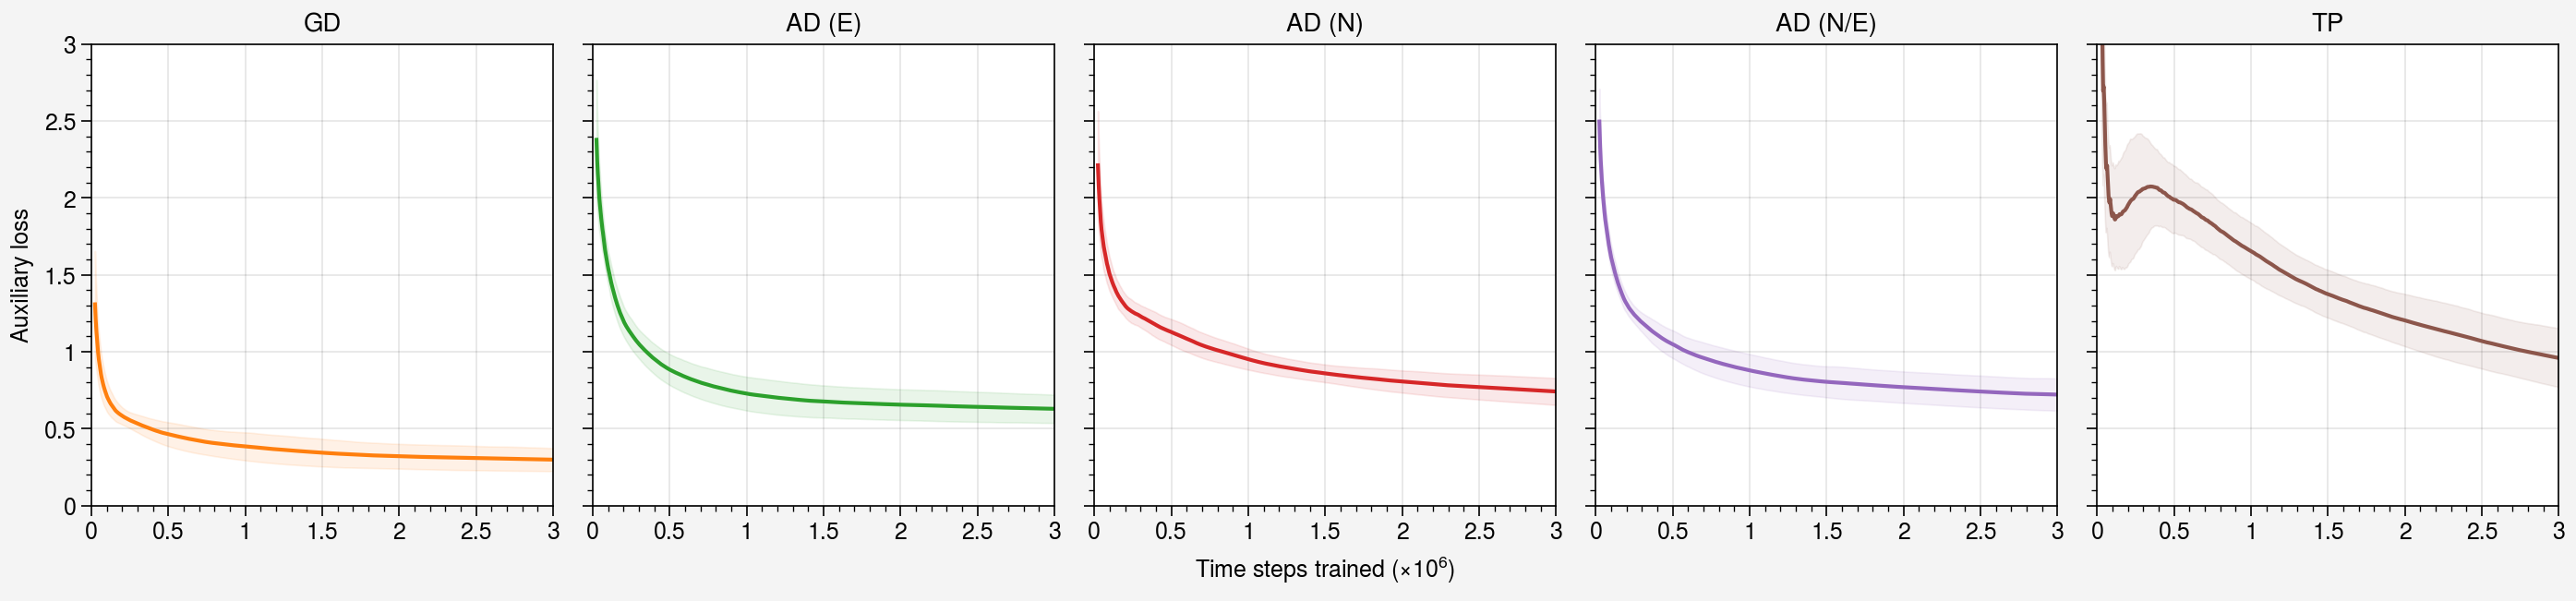

In [111]:
aux_tasks = ['goaldist', 'wall0', 'wall1', 'wall01', 'terminal']
aux_labels = ['GD', 'AD (E)', 'AD (N)', 'AD (N/E)', 'TP']

fig, ax = pplt.subplots(ncols=len(aux_tasks))

lines = []
for i, aux in enumerate(aux_tasks):
    exp_name = f'nav_pdistal_batchauxcoef1/nav_pdistal_batch32aux{aux}coef1'
    line = average_runs(exp_name, 'aux_loss', ax=ax[i], ignore_first=100, ewm=0.001, 
                        color=rgb_colors[i+1], cloud_by='std', div_x_by_mil=True)
    
    lines.append(line[0])

    # # Add batch 16 as dotted line
    # exp_name = f'nav_pdistal_batchauxcoef1/nav_pdistal_batch16aux{aux}coef1'
    # line = average_runs(exp_name, 'aux_loss', ax=ax[i], ignore_first=100, ewm=0.001, color=rgb_colors[i],
    #                    cloud_by='std', div_x_by_mil=True, ls=(0, (5, 5)), cloud_alpha=0)
    
ax.format(title=aux_labels,
         xlabel=r'Time steps trained ($\times 10^6$)', ylabel='Auxiliary loss', ylim=[0, 3],
         xlim=[0, 3])

fig.savefig('plots/paper/3_1_2_numerical_aux_losses')


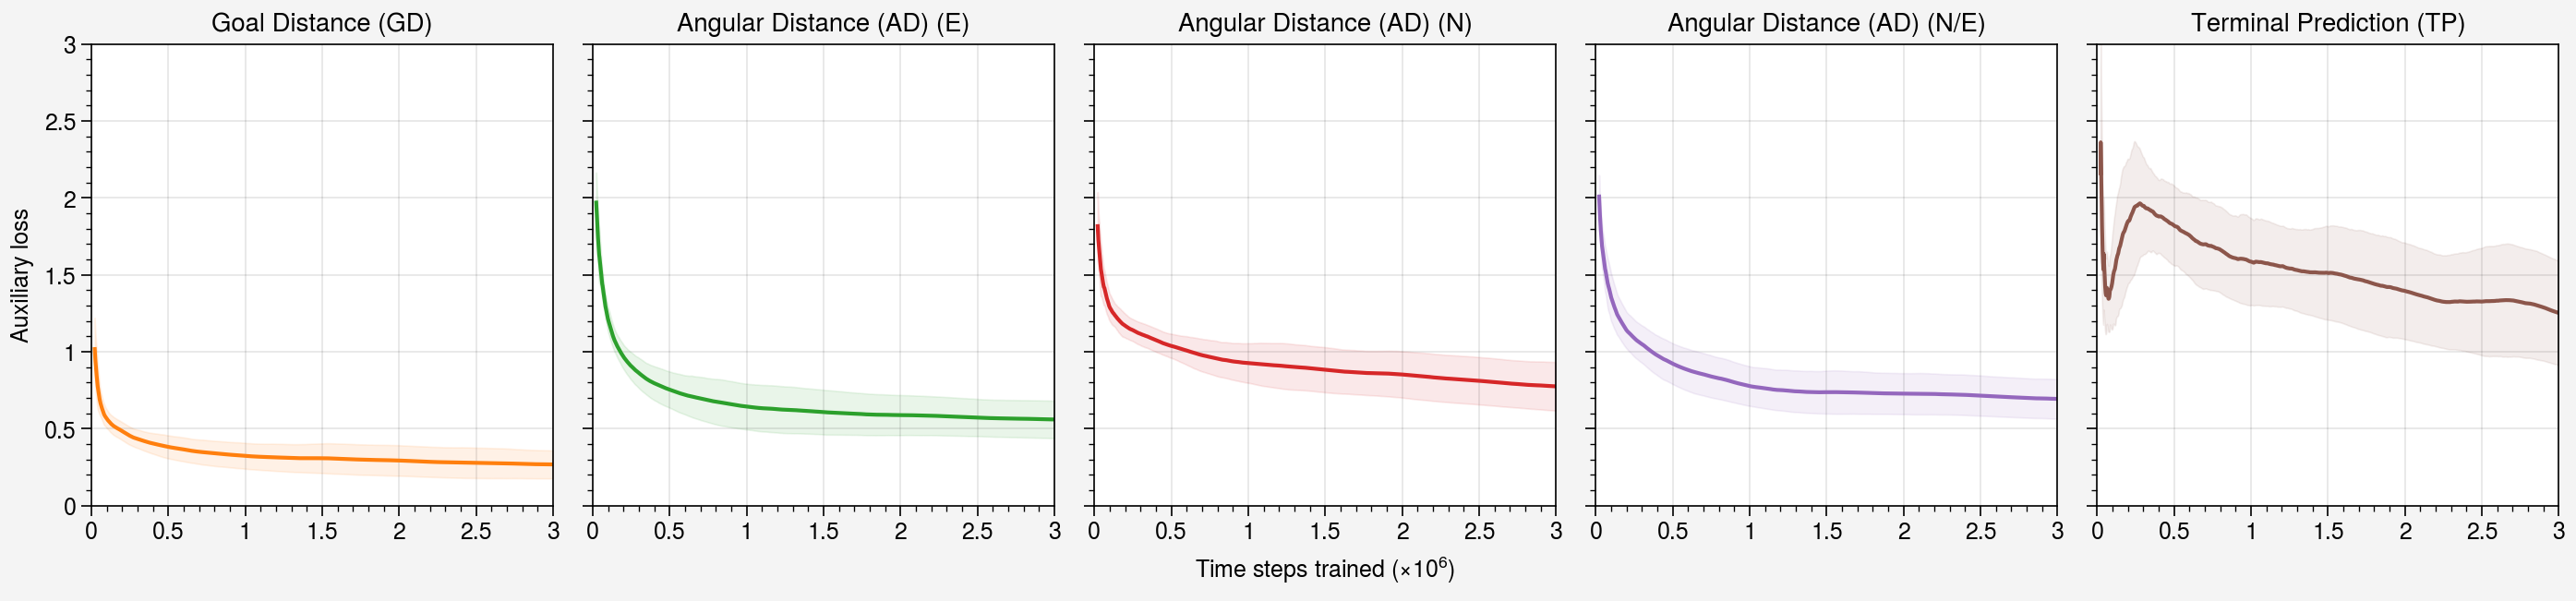

In [7]:
aux_tasks = ['goaldist', 'wall0', 'wall1', 'wall01', 'terminal']
# aux_labels = ['GD', 'AD (E)', 'AD (N)', 'AD (N/E)', 'TP']
aux_labels = ['Goal Distance (GD)', 'Angular Distance (AD) (E)', 
              'Angular Distance (AD) (N)', 'Angular Distance (AD) (N/E)', 
              'Terminal Prediction (TP)']

fig, ax = pplt.subplots(ncols=len(aux_tasks))

lines = []
for i, aux in enumerate(aux_tasks):
    exp_name = f'nav_pdistal_batchauxcoef1/nav_pdistal_batch16aux{aux}coef1'
    line = average_runs(exp_name, 'aux_loss', ax=ax[i], ignore_first=100, ewm=0.001, 
                        color=rgb_colors[i+1], cloud_by='std', div_x_by_mil=True)
    
    lines.append(line[0])

    # # Add batch 16 as dotted line
    # exp_name = f'nav_pdistal_batchauxcoef1/nav_pdistal_batch16aux{aux}coef1'
    # line = average_runs(exp_name, 'aux_loss', ax=ax[i], ignore_first=100, ewm=0.001, color=rgb_colors[i],
    #                    cloud_by='std', div_x_by_mil=True, ls=(0, (5, 5)), cloud_alpha=0)
    
ax.format(title=aux_labels,
         xlabel=r'Time steps trained ($\times 10^6$)', ylabel='Auxiliary loss', ylim=[0, 3],
         xlim=[0, 3])

fig.savefig('plots/paper/3_1_2_batch16_numerical_aux_losses')


## Categorical Auxiliary Tasks

### Performance Significance

**A: Performance at each slice of training. B: Overall learning curves, with lines showing where slices for A are taken**

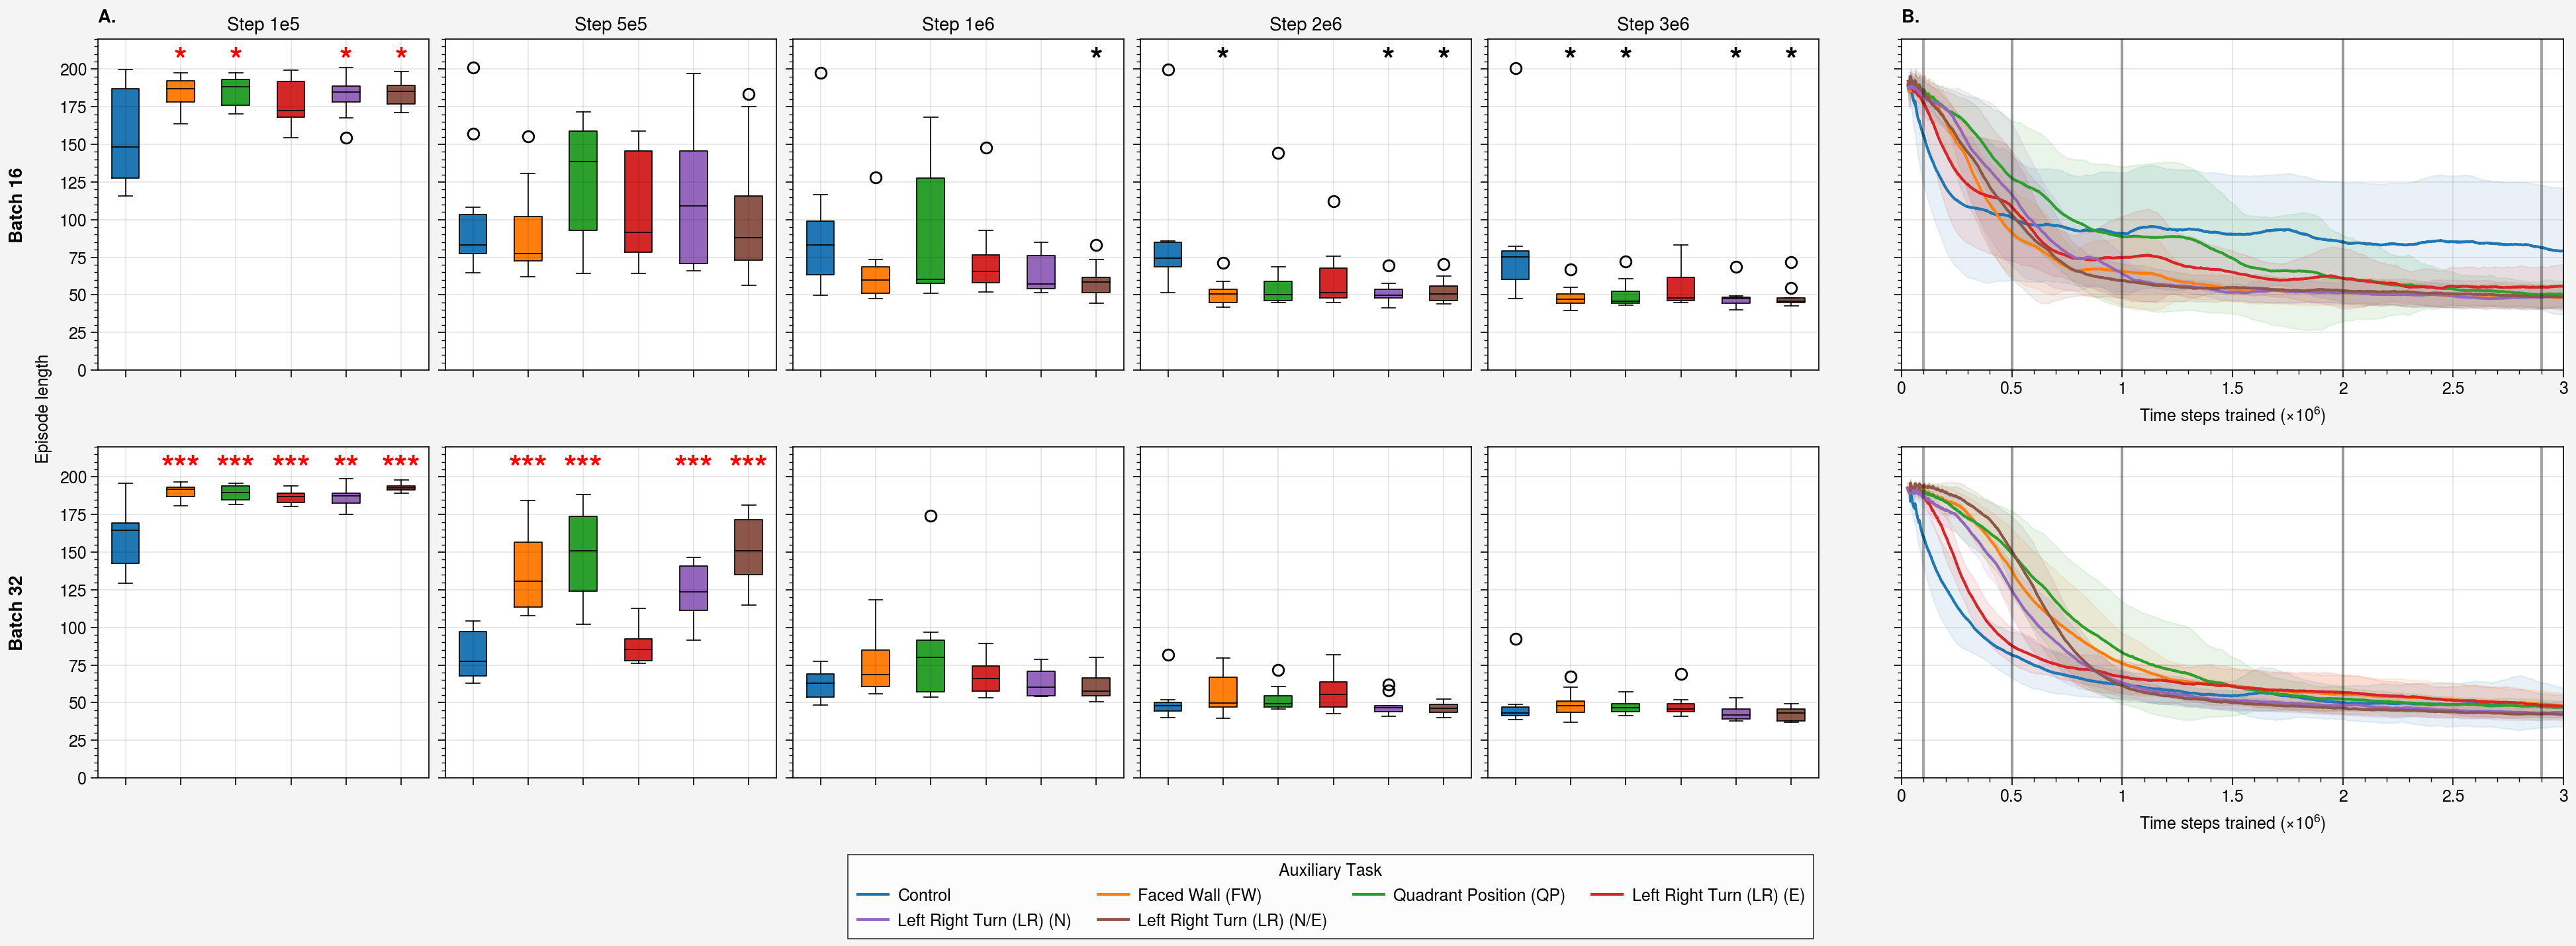

In [8]:
aux_tasks = ['none', 'catfacewall', 'catquad', 'catwall0', 'catwall1', 'catwall01']
# aux_labels = ['Control', 'FW', 'QP', 'LR (E)', 'LR (N)', 'LR (N/E)']
aux_labels = ['Control', 'Faced Wall (FW)', 'Quadrant Position (QP)', 
              'Left Right Turn (LR) (E)', 'Left Right Turn (LR) (N)', 'Left Right Turn (LR) (N/E)']
batch_sizes = [16, 32]
timepoints = [100000, 500000, 1000000, 2000000, 2900000]
timepoint_labels = ['1e5', '5e5', '1e6', '2e6', '3e6']


fig, ax = pplt.subplots(nrows=len(batch_sizes), ncols=len(timepoints)+1, 
                        wratios=(1, 1, 1, 1, 1, 2), wspace=(1, 1, 1, 1, 5),
                        sharex=False)

# Collect time points data for making box plots
y_timepoints = {}
for i, batch in enumerate(batch_sizes):
    y_timepoints[batch] = defaultdict(list)
    
    for aux in aux_tasks:
        if aux == 'none':
            exp_name = f'nav_pdistal_batchaux/nav_pdistal_batch{batch}aux{aux}'
        else:
            exp_name = f'nav_pdistal_auxcatcoef1/nav_pdistal_batch{batch}aux{aux}coef1'
            
        xs, ys, start_x, start_y = average_runs(exp_name, 'length', ignore_first=100, ewm=0.001, ret=True)
        
        for n, timepoint in enumerate(timepoints):
            idx = np.argwhere(xs > timepoint)[0][0]
            y_timepoints[batch][timepoint].append(list(ys[:, idx]))

            
# Plot boxplots with significance stars

for i, batch in enumerate(batch_sizes):
    for j, timepoint in enumerate(timepoints):
        y_samples = y_timepoints[batch][timepoint]
        
        for n in range(1, 6):
            pvalue = stats.ttest_ind(y_samples[0], y_samples[n]).pvalue
            star = ''
            if pvalue < 0.05:
                star = '*'
            if pvalue < 0.01:
                star = '**'
            if pvalue < 0.001:
                star = '***'

            if np.mean(y_samples[0]) < np.mean(y_samples[n]):
                c = 'red'
            else:
                c = 'black'

            if len(star) > 0:
                ax[i, j].text(n, 215, star, c=c, ha='center', va='top', size=18, fontweight='bold')
        
        ax[i, j].boxplot(np.array(y_samples).T, fill=True,
          cycle=[list(rgb_colors[i]) for i in range(6)])
            


# Plot learning curves

for i, batch in enumerate(batch_sizes):
    lines = []
    for n, aux in enumerate(aux_tasks):
        if aux == 'none':
            exp_name = f'nav_pdistal_batchaux/nav_pdistal_batch{batch}aux{aux}'
        else:
            exp_name = f'nav_pdistal_auxcatcoef1/nav_pdistal_batch{batch}aux{aux}coef1'
            
        # exp_name = f'nav_pdistal_auxcat/nav_pdistal_width{width}aux{aux}'

        line = average_runs(exp_name, 'length', ax=ax[i, -1], ignore_first=100, ewm=0.001, color=rgb_colors[n],
                           cloud_by='std', div_x_by_mil=True)
        lines.append(line[0])

# Add time point lines to learning curves

timepoints = np.array([100000, 500000, 1000000, 2000000, 2900000])/1000000
for timepoint in timepoints:
    for i in range(2):
        ax[i, -1].plot([timepoint, timepoint], [-10, 230], 'black', alpha=0.35)
        
        

#Formatting 

add_abc_to_subaxes(ax[0, 0], 'A.')
add_abc_to_subaxes(ax[0, 5], 'B.')

ax[:, -1].format(xlabel=r'Time steps trained ($\times 10^6$)', ylabel='Episode length',
         ylim=[0, 220], xlim=[0, 3])
ax[0, :-1].format(title=[f'Step {step}' for step in timepoint_labels])

## Include x labels on box plots
# ax[:, :-1].format(xticklabels=aux_labels, xrotation=45,
#           leftlabels=[f'Batcch {batch}' for batch in batch_sizes],
#           ylim=[0, 220])
# No x labels for box plots
ax[:, :-1].format(leftlabels=[f'Batch {batch}' for batch in batch_sizes],
          ylim=[0, 220], xticklabels=[])

fig.legend(lines, loc='b', ncols=4, labels=aux_labels, 
           title='Auxiliary Task')

fig.savefig('plots/paper/3_2_1_categorical_learning_performance')


### Losses

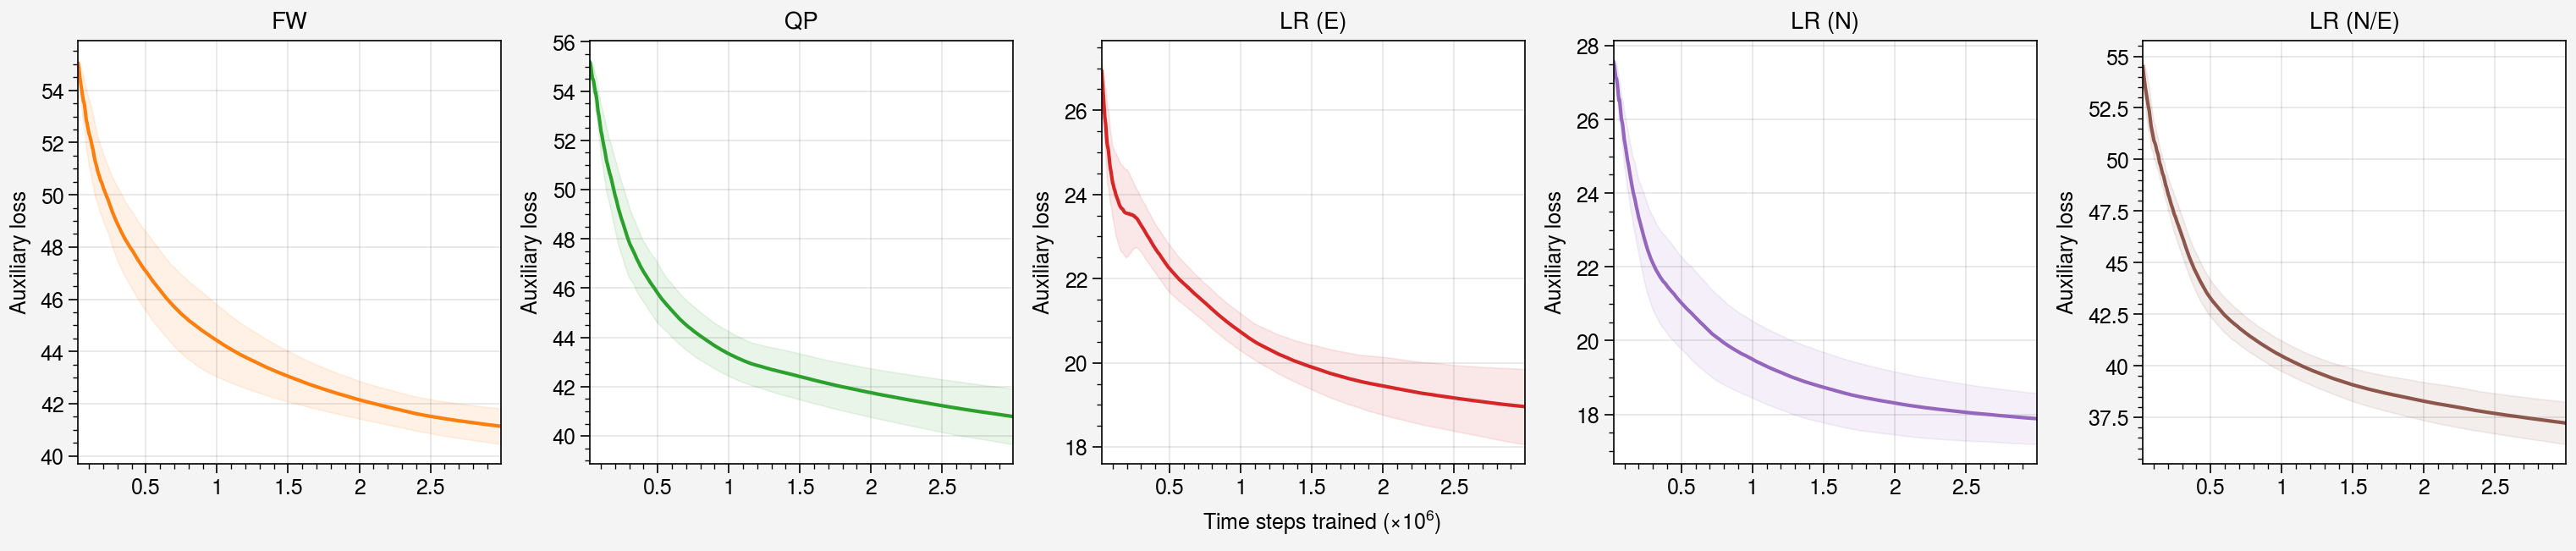

In [8]:
aux_tasks = ['catfacewall', 'catquad', 'catwall0', 'catwall1', 'catwall01']
aux_labels = ['FW', 'QP', 'LR (E)', 'LR (N)', 'LR (N/E)']

batch = 32

fig, ax = pplt.subplots(ncols=len(aux_tasks), sharey=False)

lines = []
for i, aux in enumerate(aux_tasks):
    exp_name = f'nav_pdistal_auxcatcoef1/nav_pdistal_batch{batch}aux{aux}coef1'
    line = average_runs(exp_name, 'aux_loss', ax=ax[i], ignore_first=100, ewm=0.001, 
                        color=rgb_colors[i+1], cloud_by='std', div_x_by_mil=True)
    lines.append(line[0])
    
ax.format(title=aux_labels,
         xlabel=r'Time steps trained ($\times 10^6$)', ylabel='Auxiliary loss')

fig.savefig('plots/paper/3_2_2_categorical_aux_losses')



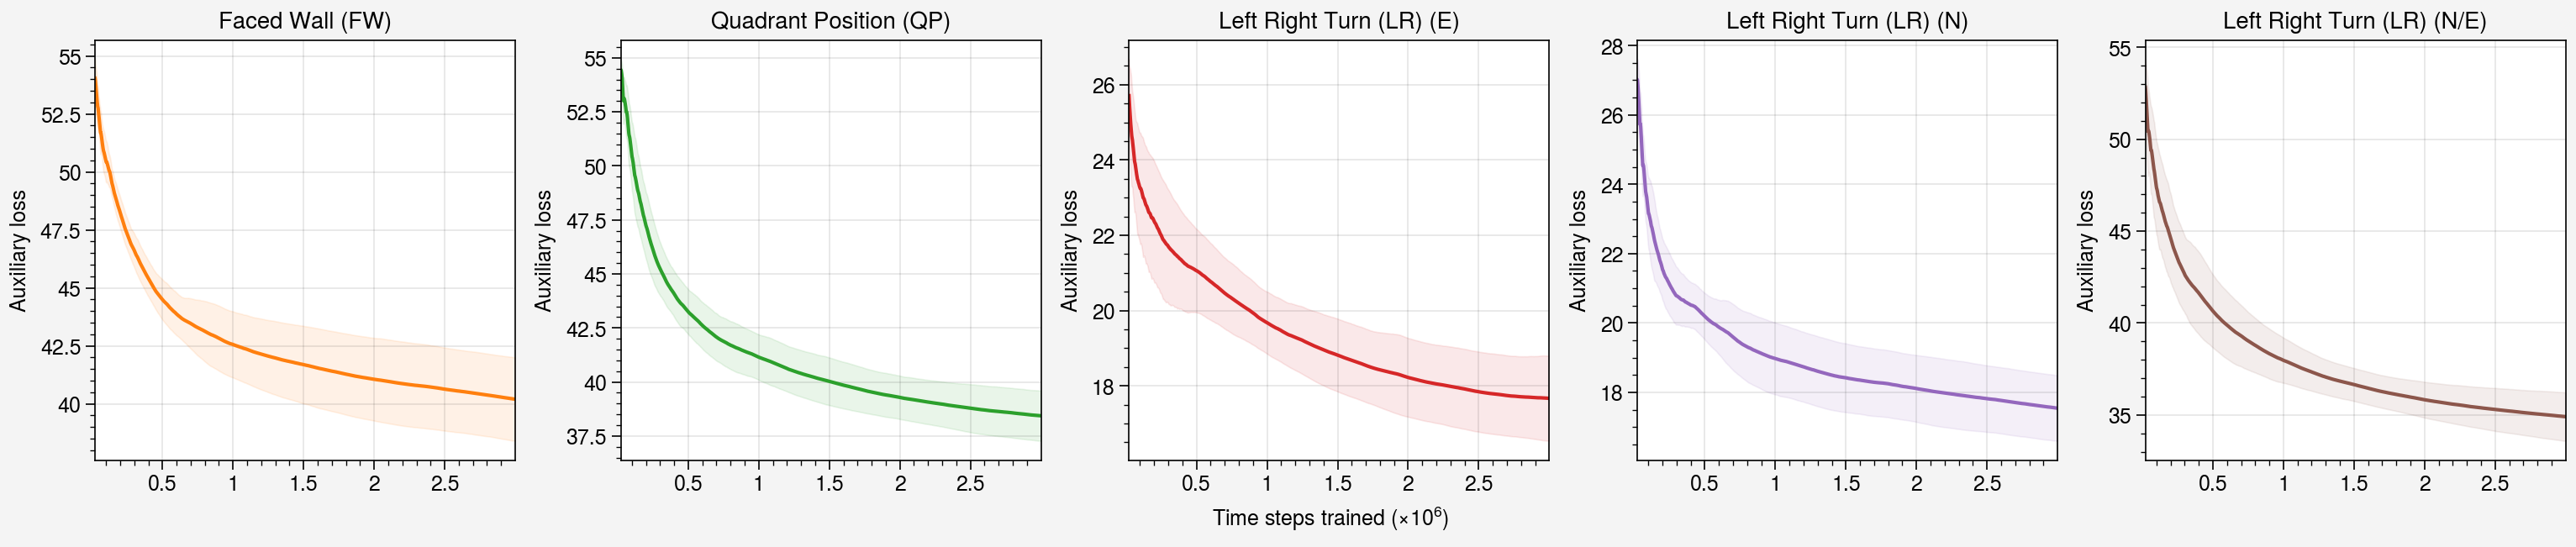

In [9]:
aux_tasks = ['catfacewall', 'catquad', 'catwall0', 'catwall1', 'catwall01']
# aux_labels = ['FW', 'QP', 'LR (E)', 'LR (N)', 'LR (N/E)']
aux_labels = ['Faced Wall (FW)', 'Quadrant Position (QP)', 
              'Left Right Turn (LR) (E)', 'Left Right Turn (LR) (N)', 'Left Right Turn (LR) (N/E)']

batch = 16

fig, ax = pplt.subplots(ncols=len(aux_tasks), sharey=False)

lines = []
for i, aux in enumerate(aux_tasks):
    exp_name = f'nav_pdistal_auxcatcoef1/nav_pdistal_batch{batch}aux{aux}coef1'
    line = average_runs(exp_name, 'aux_loss', ax=ax[i], ignore_first=100, ewm=0.001, 
                        color=rgb_colors[i+1], cloud_by='std', div_x_by_mil=True)
    lines.append(line[0])
    
ax.format(title=aux_labels,
         xlabel=r'Time steps trained ($\times 10^6$)', ylabel='Auxiliary loss')

fig.savefig('plots/paper/3_2_2_batch16_categorical_aux_losses')



## Reward Auxiliary Tasks

### Performance Significance

**A: Performance at each slice of training. B: Overall learning curves, with lines showing where slices for A are taken**

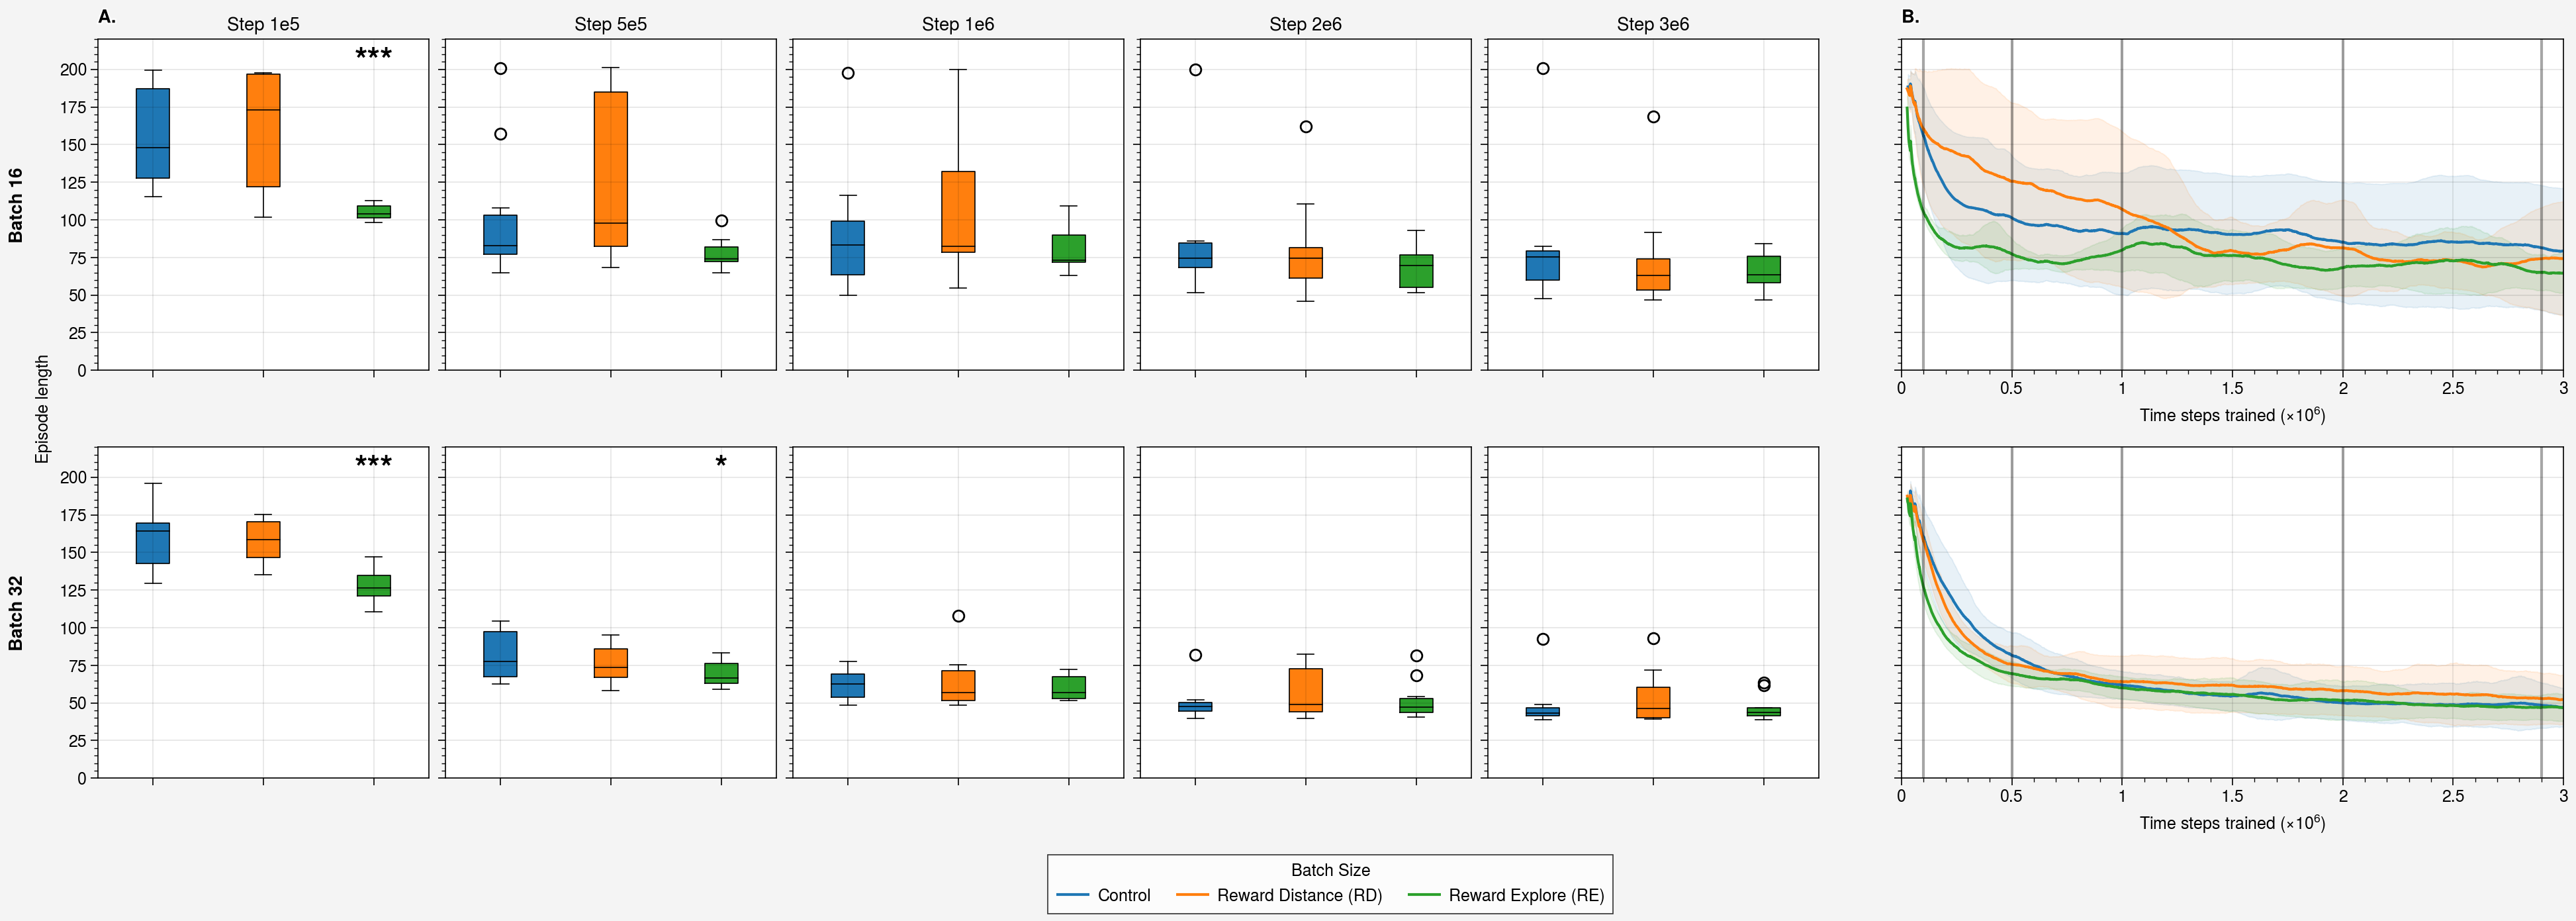

In [10]:
aux_tasks = ['none', 'rewdistscale0015', 'rewexplore']
# aux_labels = ['Control', 'RD', 'RE']
aux_labels = ['Control', 'Reward Distance (RD)', 'Reward Explore (RE)']
batch_sizes = [16, 32]
timepoints = [100000, 500000, 1000000, 2000000, 2900000]
timepoint_labels = ['1e5', '5e5', '1e6', '2e6', '3e6']


fig, ax = pplt.subplots(nrows=len(batch_sizes), ncols=len(timepoints)+1, 
                        wratios=(1, 1, 1, 1, 1, 2), wspace=(1, 1, 1, 1, 5),
                        sharex=False)

# Collect time points data for making box plots
y_timepoints = {}
for i, batch in enumerate(batch_sizes):
    y_timepoints[batch] = defaultdict(list)
    
    for aux in aux_tasks:
        if aux == 'none':
            exp_name = f'nav_pdistal_batchaux/nav_pdistal_batch{batch}aux{aux}'
        else:
            exp_name = f'nav_pdistal_batchaux/nav_pdistal_batch{batch}aux{aux}'
            
        xs, ys, start_x, start_y = average_runs(exp_name, 'length', 
                                                ignore_first=100, ewm=0.001, 
                                                ret=True)
        
        for n, timepoint in enumerate(timepoints):
            idx = np.argwhere(xs > timepoint)[0][0]
            y_timepoints[batch][timepoint].append(list(ys[:, idx]))

            
# Plot boxplots with significance stars

for i, batch in enumerate(batch_sizes):
    for j, timepoint in enumerate(timepoints):
        y_samples = y_timepoints[batch][timepoint]
        
        for n in range(1, len(aux_tasks)):
            pvalue = stats.ttest_ind(y_samples[0], y_samples[n]).pvalue
            star = ''
            if pvalue < 0.05:
                star = '*'
            if pvalue < 0.01:
                star = '**'
            if pvalue < 0.001:
                star = '***'

            if np.mean(y_samples[0]) < np.mean(y_samples[n]):
                c = 'red'
            else:
                c = 'black'

            if len(star) > 0:
                ax[i, j].text(n, 215, star, c=c, ha='center', va='top', 
                              size=18, fontweight='bold')
        
        ax[i, j].boxplot(np.array(y_samples).T, fill=True,
          cycle=[list(rgb_colors[i]) for i in range(len(aux_tasks))])
            


# Plot learning curves

for i, batch in enumerate(batch_sizes):
    lines = []
    for n, aux in enumerate(aux_tasks):
        if aux == 'none':
            exp_name = f'nav_pdistal_batchaux/nav_pdistal_batch{batch}aux{aux}'
        else:
            exp_name = f'nav_pdistal_batchaux/nav_pdistal_batch{batch}aux{aux}'
            
        # exp_name = f'nav_pdistal_auxcat/nav_pdistal_width{width}aux{aux}'

        line = average_runs(exp_name, 'length', ax=ax[i, -1], ignore_first=100, 
                            ewm=0.001, color=rgb_colors[n],
                            cloud_by='std', div_x_by_mil=True)
        lines.append(line[0])

# Add time point lines to learning curves

timepoints = np.array([100000, 500000, 1000000, 2000000, 2900000])/1000000
for timepoint in timepoints:
    for i in range(2):
        ax[i, -1].plot([timepoint, timepoint], [-10, 230], 'black', alpha=0.35)
        
        

#Formatting 

add_abc_to_subaxes(ax[0, 0], 'A.')
add_abc_to_subaxes(ax[0, 5], 'B.')

ax[:, -1].format(xlabel=r'Time steps trained ($\times 10^6$)', 
                 ylabel='Episode length',
         ylim=[0, 220], xlim=[0, 3])
ax[0, :-1].format(title=[f'Step {step}' for step in timepoint_labels])

## Include x labels on box plots
# ax[:, :-1].format(xticklabels=aux_labels, xrotation=45,
#           leftlabels=[f'Batcch {batch}' for batch in batch_sizes],
#           ylim=[0, 220])
# No x labels for box plots
ax[:, :-1].format(leftlabels=[f'Batch {batch}' for batch in batch_sizes],
          ylim=[0, 220], xticklabels=[])

fig.legend(lines, loc='b', ncols=4, labels=aux_labels, 
           title='Batch Size')

fig.savefig('plots/paper/3_3_1_reward_learning_performance')


# Cosine Similarities

## Supervised Means

**16 Batch Size Agents. A: Numerical Tasks, B: Categorical Tasks**

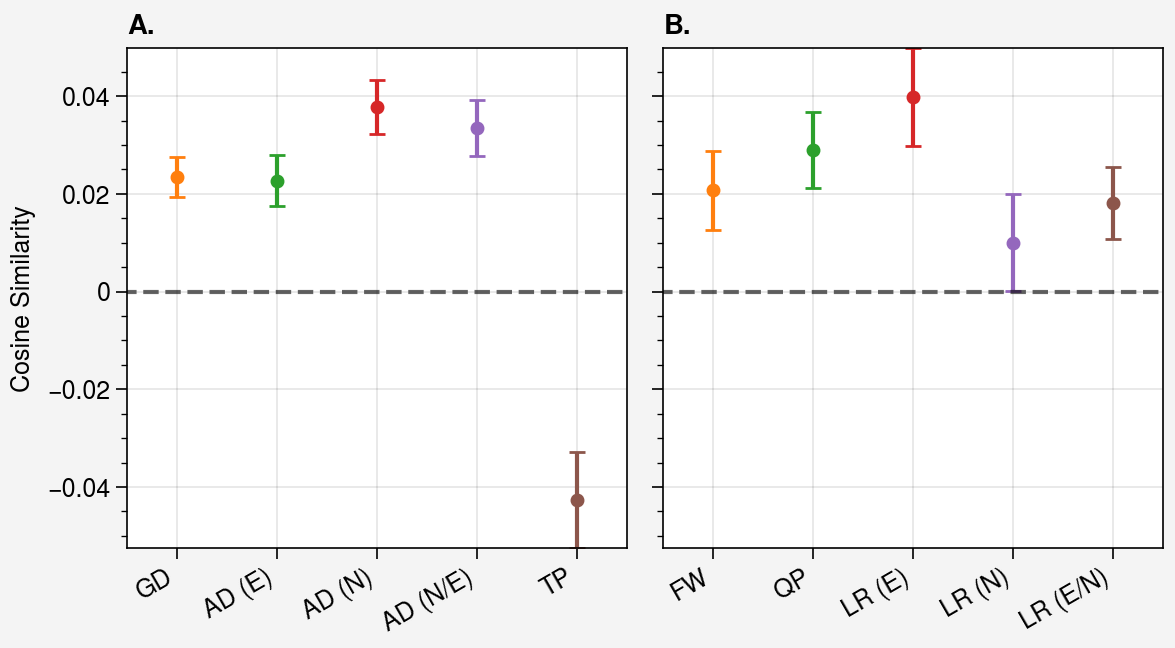

In [27]:
all_cs_means = {
    'num': pickle.load(open('data/grads/aux_100cs', 'rb')),
    'cat': pickle.load(open('data/grads/auxcat_100cs', 'rb'))
}
all_aux_tasks = {
    'num': ['goaldist', 'wall0', 'wall1', 'wall01', 'terminal'],
    'cat': ['catfacewall', 'catquad', 'catwall0', 'catwall1', 'catwall01']
}
all_aux_labels = {
    'num': ['GD', 'AD (E)', 'AD (N)', 'AD (N/E)', 'TP'],
    'cat': ['FW', 'QP', 'LR (E)', 'LR (N)', 'LR (E/N)']
}

trials = range(10)
all_chks = {16: [0, 50, 100, 150, 300, 600, 1000, 1500],
            32: [0, 20, 40, 80, 150, 300, 600, 900]}


batch = 16
    


fig, ax = pplt.subplots(ncols=len(batch_sizes))

for i, typ in enumerate(['num', 'cat']):
    xs = []
    trial_means = []
    errors = []

    cs_means = all_cs_means[typ]
    aux_tasks = all_aux_tasks[typ]
    
    for j, aux in enumerate(aux_tasks):
        chks = all_chks[batch]
        xs.append(j)
        
        cos_sims = []
        for trial in trials:
            for chk in chks:
                cs = cs_means[batch][aux][trial][chk]
                cos_sims.append(cs)
        cs = np.array(cos_sims).reshape(-1)
        mean = np.mean(cs)
        interval = stats.t.interval(alpha=0.95, df=len(cs)-1, 
                         loc=mean, scale=stats.sem(cs))

        errors.append(interval[1] - mean)
        trial_means.append(mean)

    for j in range(len(xs)):
        ax[i].errorbar(xs[j], trial_means[j], errors[j], linestyle='',
                          marker='o', markersize=4, c=rgb_colors[j+1])
    
for i in range(len(batch_sizes)):
    ax[i].plot([-1, 5], [0, 0], '--k', alpha=0.6)
    
ax.format(abc='A.', abcloc='l', xlocator=range(5), xlim=[-0.5, 4.5],
          ylabel='Cosine Similarity')

for i, typ in enumerate(['num', 'cat']):
    ax[i].format(xticklabels=all_aux_labels[typ],
                xrotation=30)
    
fig.savefig('plots/paper/4_1_supervised_cos_sim_means')

**32 Batch Size Agents. A: Numerical Tasks, B: Categorical Tasks**

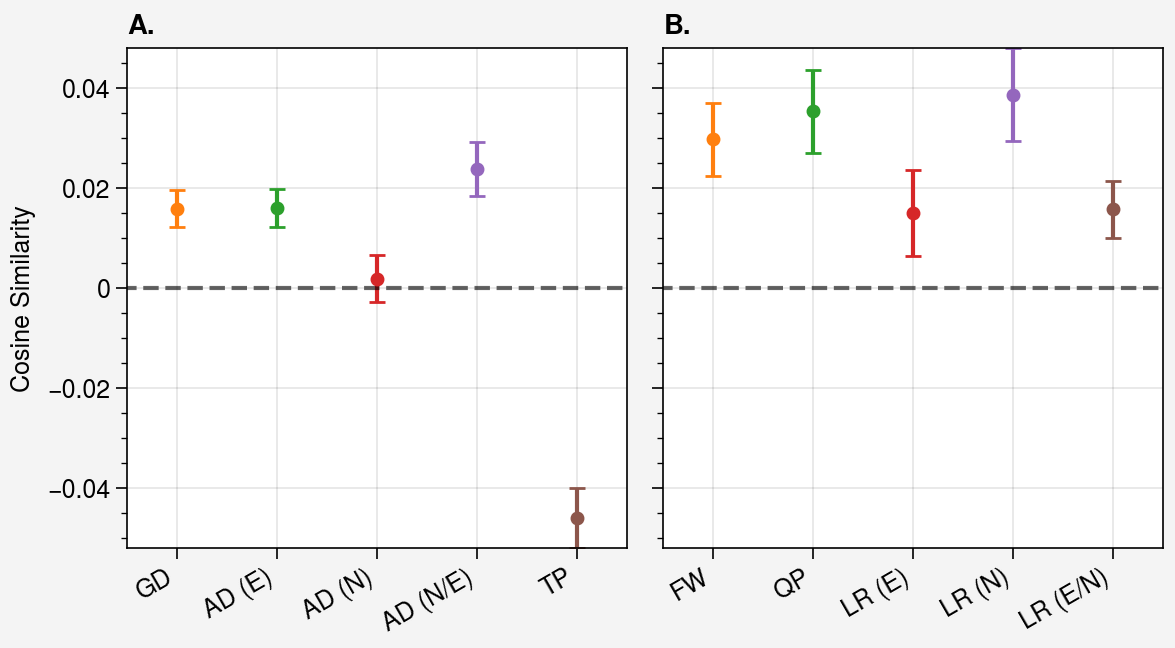

In [52]:
all_cs_means = {
    'num': pickle.load(open('data/grads/aux_100cs', 'rb')),
    'cat': pickle.load(open('data/grads/auxcat_100cs', 'rb'))
}
all_aux_tasks = {
    'num': ['goaldist', 'wall0', 'wall1', 'wall01', 'terminal'],
    'cat': ['catfacewall', 'catquad', 'catwall0', 'catwall1', 'catwall01']
}
all_aux_labels = {
    'num': ['GD', 'AD (E)', 'AD (N)', 'AD (N/E)', 'TP'],
    'cat': ['FW', 'QP', 'LR (E)', 'LR (N)', 'LR (E/N)']
}

trials = range(10)
all_chks = {16: [0, 50, 100, 150, 300, 600, 1000, 1500],
            32: [0, 20, 40, 80, 150, 300, 600, 900]}


batch = 32
    


fig, ax = pplt.subplots(ncols=len(batch_sizes))

for i, typ in enumerate(['num', 'cat']):
    xs = []
    trial_means = []
    errors = []

    cs_means = all_cs_means[typ]
    aux_tasks = all_aux_tasks[typ]
    
    for j, aux in enumerate(aux_tasks):
        chks = all_chks[batch]
        xs.append(j)
        
        cos_sims = []
        for trial in trials:
            for chk in chks:
                cs = cs_means[batch][aux][trial][chk]
                cos_sims.append(cs)
        cs = np.array(cos_sims).reshape(-1)
        mean = np.mean(cs)
        interval = stats.t.interval(alpha=0.95, df=len(cs)-1, 
                         loc=mean, scale=stats.sem(cs))

        errors.append(interval[1] - mean)
        trial_means.append(mean)

    for j in range(len(xs)):
        ax[i].errorbar(xs[j], trial_means[j], errors[j], linestyle='',
                          marker='o', markersize=4, c=rgb_colors[j+1])
    
for i in range(len(batch_sizes)):
    ax[i].plot([-1, 5], [0, 0], '--k', alpha=0.6)
    
ax.format(abc='A.', abcloc='l', xlocator=range(5), xlim=[-0.5, 4.5],
          ylabel='Cosine Similarity')

for i, typ in enumerate(['num', 'cat']):
    ax[i].format(xticklabels=all_aux_labels[typ],
                xrotation=30)
    
fig.savefig('plots/paper/4_1_supervised_cos_sim_means')

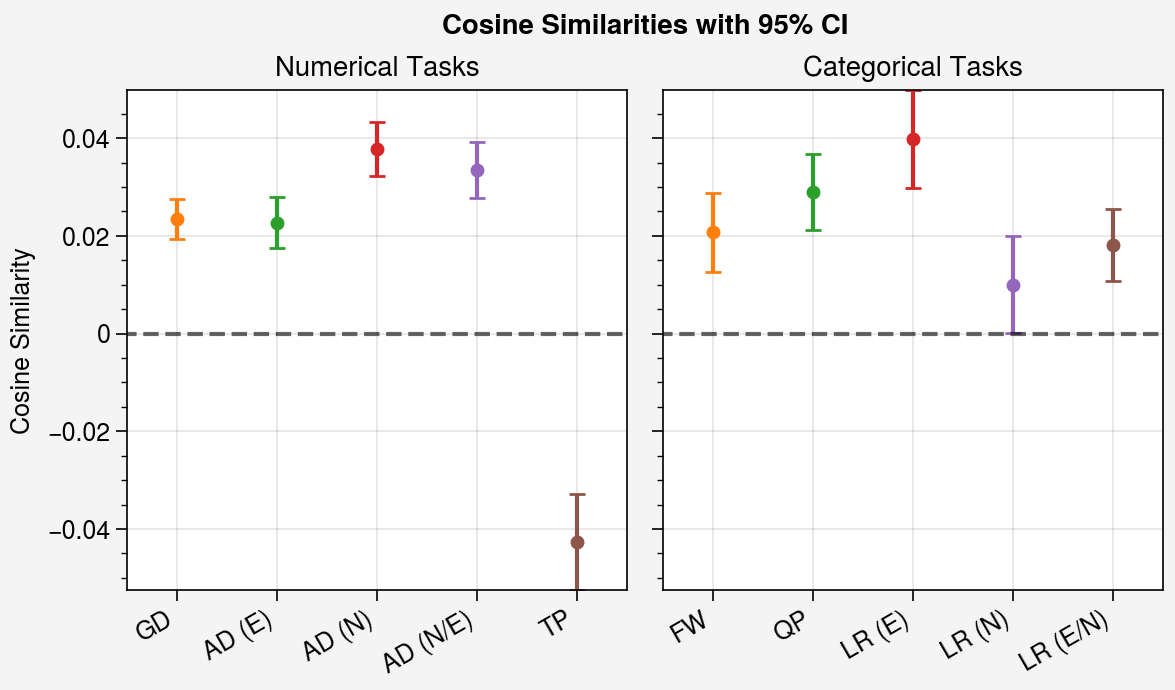

In [ ]:
all_cs_means = {
    'num': pickle.load(open('data/grads/aux_100cs', 'rb')),
    'cat': pickle.load(open('data/grads/auxcat_100cs', 'rb'))
}
all_aux_tasks = {
    'num': ['goaldist', 'wall0', 'wall1', 'wall01', 'terminal'],
    'cat': ['catfacewall', 'catquad', 'catwall0', 'catwall1', 'catwall01']
}
all_aux_labels = {
    'num': ['GD', 'AD (E)', 'AD (N)', 'AD (N/E)', 'TP'],
    'cat': ['FW', 'QP', 'LR (E)', 'LR (N)', 'LR (E/N)']
}

trials = range(10)
all_chks = {16: [0, 50, 100, 150, 300, 600, 1000, 1500],
            32: [0, 20, 40, 80, 150, 300, 600, 900]}


batch = 16
    


fig, ax = pplt.subplots(ncols=len(batch_sizes))

for i, typ in enumerate(['num', 'cat']):
    xs = []
    trial_means = []
    errors = []

    cs_means = all_cs_means[typ]
    aux_tasks = all_aux_tasks[typ]
    
    for j, aux in enumerate(aux_tasks):
        chks = all_chks[batch]
        xs.append(j)
        
        cos_sims = []
        for trial in trials:
            for chk in chks:
                cs = cs_means[batch][aux][trial][chk]
                cos_sims.append(cs)
        cs = np.array(cos_sims).reshape(-1)
        mean = np.mean(cs)
        interval = stats.t.interval(alpha=0.95, df=len(cs)-1, 
                         loc=mean, scale=stats.sem(cs))

        errors.append(interval[1] - mean)
        trial_means.append(mean)

    for j in range(len(xs)):
        ax[i].errorbar(xs[j], trial_means[j], errors[j], linestyle='',
                          marker='o', markersize=4, c=rgb_colors[j+1])
    
for i in range(len(batch_sizes)):
    ax[i].plot([-1, 5], [0, 0], '--k', alpha=0.6)
    
ax.format(xlocator=range(5), xlim=[-0.5, 4.5],
          ylabel='Cosine Similarity', title=['Numerical Tasks', 'Categorical Tasks'],
          suptitle='Cosine Similarities with 95% CI')

for i, typ in enumerate(['num', 'cat']):
    ax[i].format(xticklabels=all_aux_labels[typ],
                xrotation=30)
    
# fig.savefig('plots/paper/4_1_supervised_cos_sim_means')

### Checkpoints Selected Example

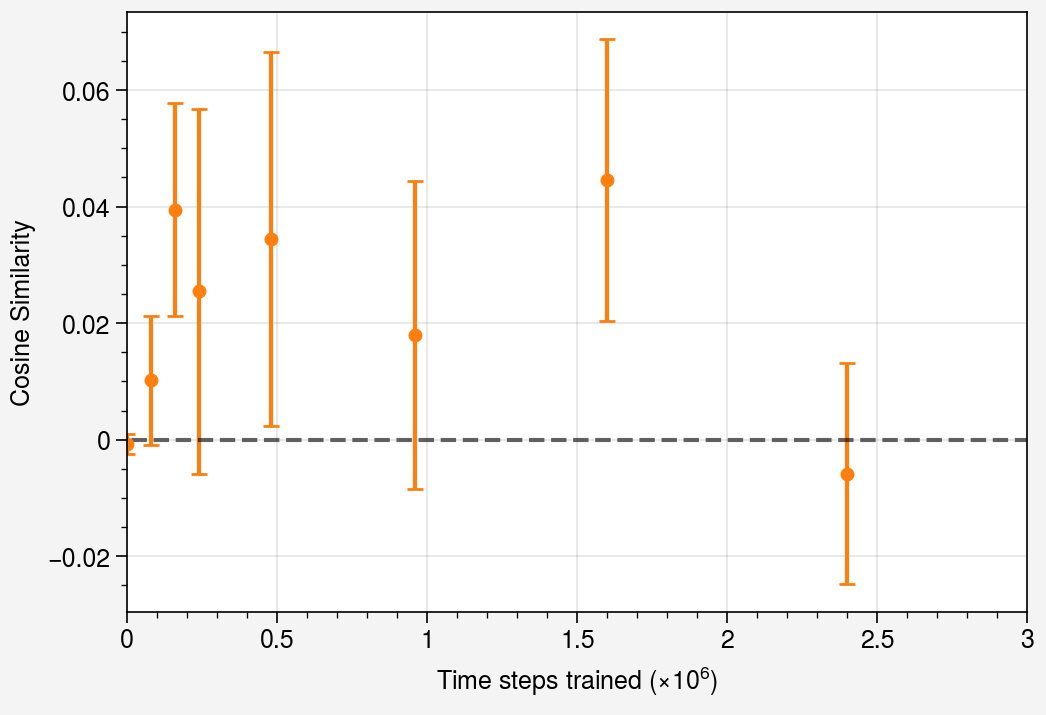

In [60]:
cs_means = pickle.load(open('data/grads/auxcat_100cs', 'rb'))
aux = 'catfacewall'

trials = range(10)
all_chks = {16: [0, 50, 100, 150, 300, 600, 1000, 1500],
            32: [0, 20, 40, 80, 150, 300, 600, 900]}

batch = 16

fig, ax = pplt.subplots(refaspect=1.5, refheight=3)

chk_means = []
errors = []
xs = []

chks = all_chks[batch]

for chk in chks:
    xs.append(chk * batch * 100 / 1000000)
    cos_sims = []
    for trial in trials:
        cs = cs_means[batch][aux][trial][chk]
        cos_sims.append(cs)
    cs = np.array(cos_sims).reshape(-1)
    mean = np.mean(cs)
    interval = stats.t.interval(alpha=0.95, df=len(cs)-1, 
                     loc=mean, scale=stats.sem(cs))

    errors.append(interval[1] - mean)
    chk_means.append(mean)

    
ax.errorbar(xs, chk_means, errors, linestyle='',
                  marker='o', markersize=4, c=rgb_colors[1])

ax.plot([-1, 3], [0, 0], '--k', alpha=0.6)

ax.format(xlim=[0, 3], ylabel='Cosine Similarity',
          xlabel=r'Time steps trained ($\times 10^6$)')

fig.savefig('plots/paper/4_1_1_facewall_cos_sim_example')

### Checkpoints per Task

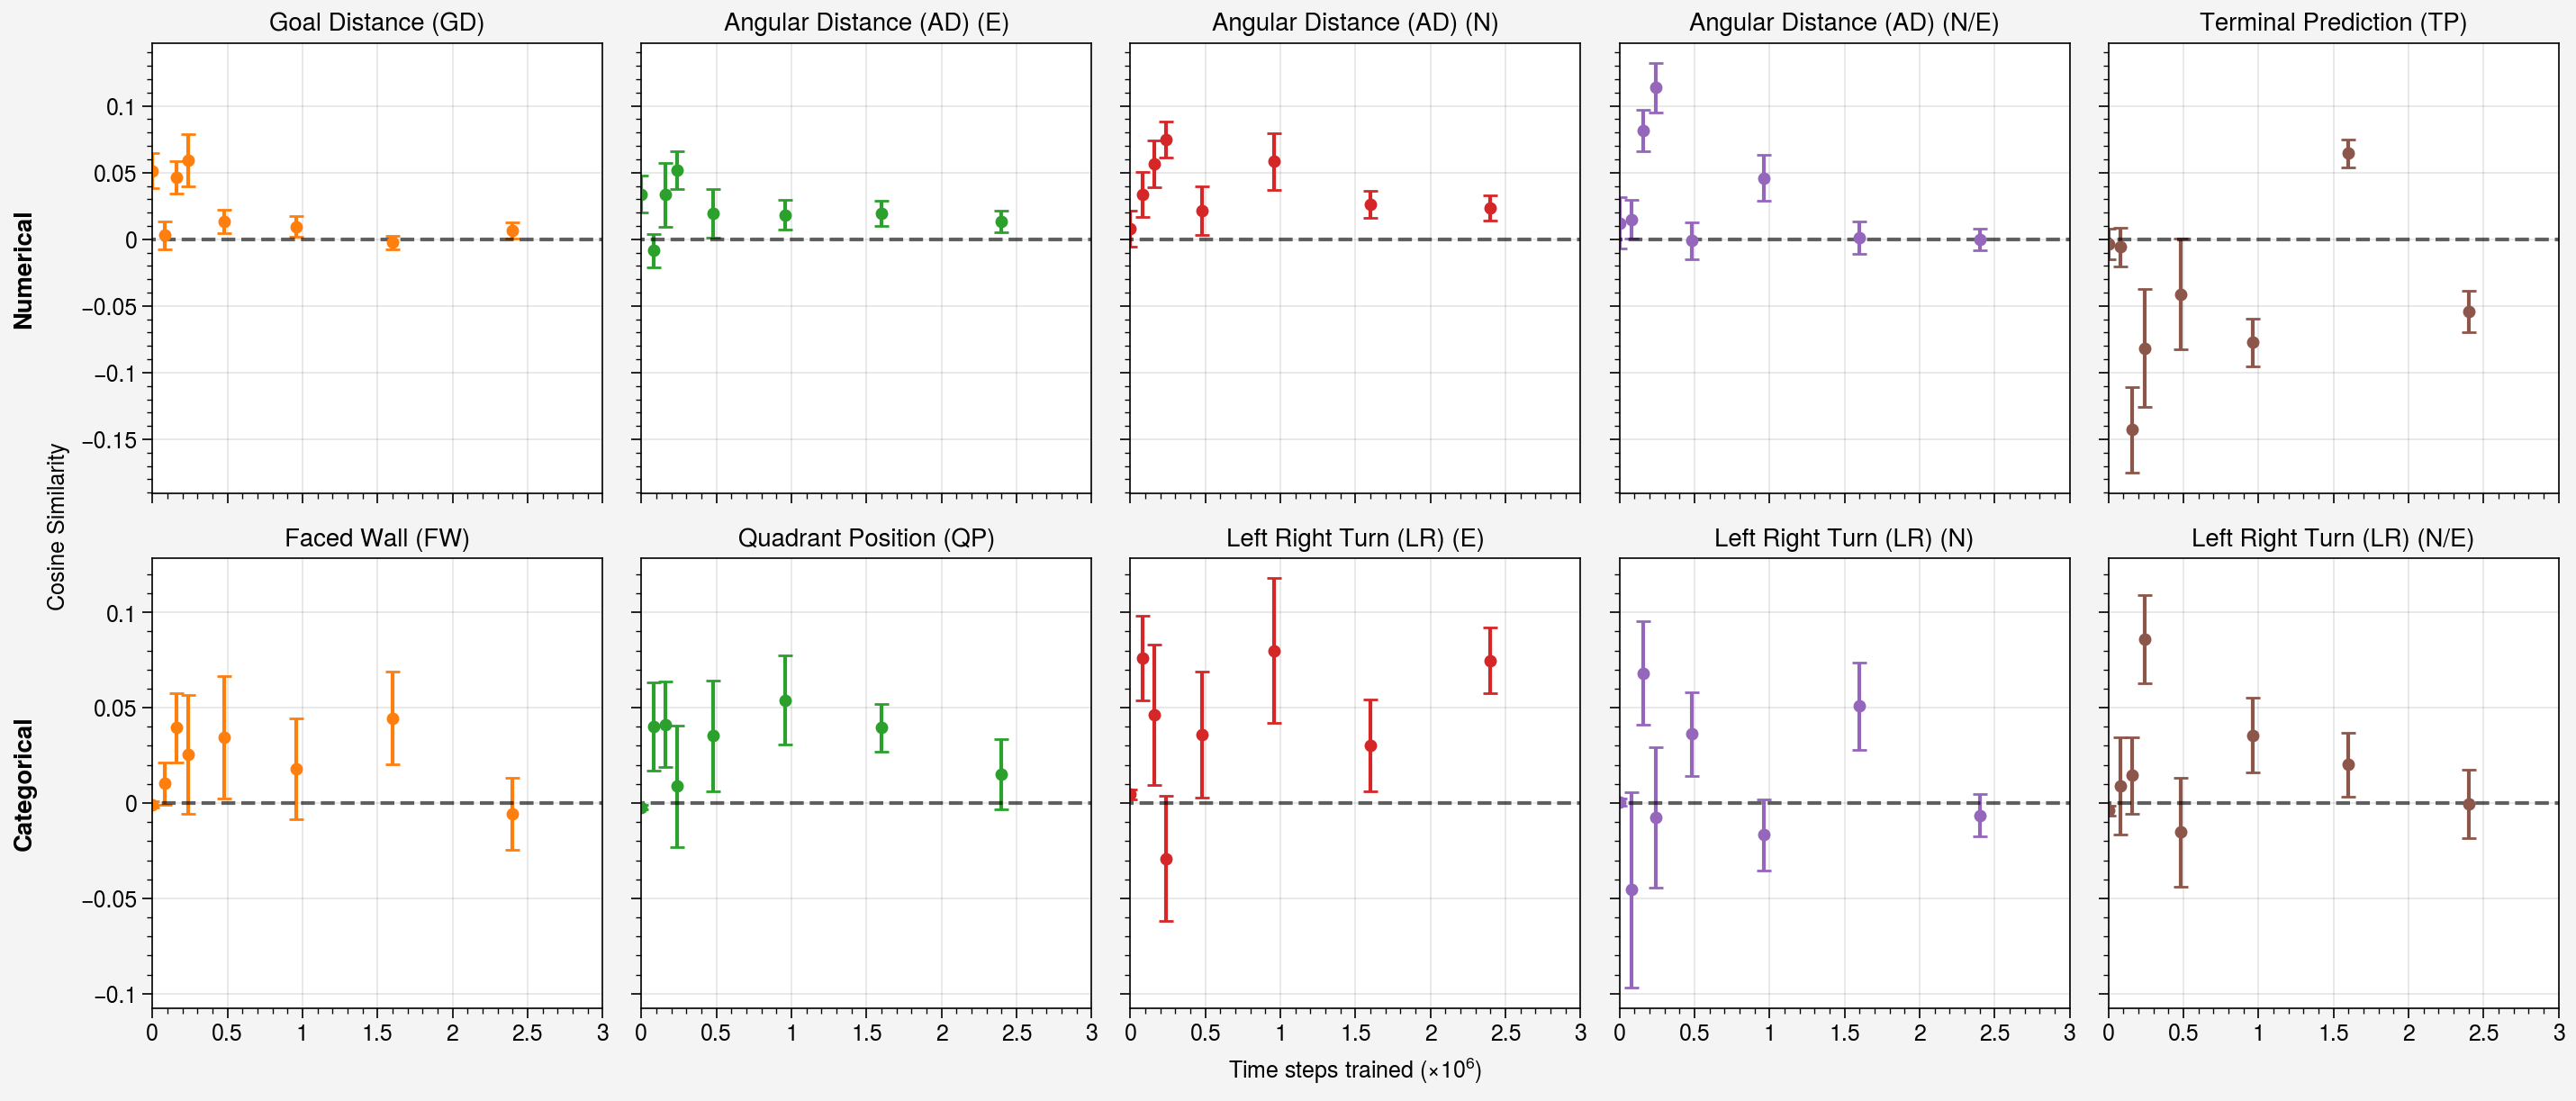

In [13]:
all_cs_means = {
    'num': pickle.load(open('data/grads/aux_100cs', 'rb')),
    'cat': pickle.load(open('data/grads/auxcat_100cs', 'rb'))
}
all_aux_tasks = {
    'num': ['goaldist', 'wall0', 'wall1', 'wall01', 'terminal'],
    'cat': ['catfacewall', 'catquad', 'catwall0', 'catwall1', 'catwall01']
}
all_aux_labels = {
    # 'num': ['GD', 'AD (E)', 'AD (N)', 'AD (N/E)', 'TP'],
    'num': ['Goal Distance (GD)', 'Angular Distance (AD) (E)', 
              'Angular Distance (AD) (N)', 'Angular Distance (AD) (N/E)', 
              'Terminal Prediction (TP)'],
    # 'cat': ['FW', 'QP', 'LR (E)', 'LR (N)', 'LR (E/N)']
    'cat': ['Faced Wall (FW)', 'Quadrant Position (QP)', 
              'Left Right Turn (LR) (E)', 'Left Right Turn (LR) (N)', 'Left Right Turn (LR) (N/E)']
}

trials = range(10)
all_chks = {16: [0, 50, 100, 150, 300, 600, 1000, 1500],
            32: [0, 20, 40, 80, 150, 300, 600, 900]}

batch = 16

fig, ax = pplt.subplots(nrows=2, ncols=5)


for i, typ in enumerate(['num', 'cat']):
    cs_means = all_cs_means[typ]
    aux_tasks = all_aux_tasks[typ]
    
    for j, aux in enumerate(aux_tasks):
        chk_means = []
        errors = []
        xs = []

        chks = all_chks[batch]

        for chk in chks:
            xs.append(chk * batch * 100 / 1000000)
            cos_sims = []
            for trial in trials:
                cs = cs_means[batch][aux][trial][chk]
                cos_sims.append(cs)
            cs = np.array(cos_sims).reshape(-1)
            mean = np.mean(cs)
            interval = stats.t.interval(alpha=0.95, df=len(cs)-1, 
                             loc=mean, scale=stats.sem(cs))

            errors.append(interval[1] - mean)
            chk_means.append(mean)


        ax[i, j].errorbar(xs, chk_means, errors, linestyle='',
                          marker='o', markersize=4, c=rgb_colors[j+1])

        ax[i, j].plot([-1, 3], [0, 0], '--k', alpha=0.6)

ax.format(xlim=[0, 3], ylabel='Cosine Similarity',
          xlabel=r'Time steps trained ($\times 10^6$)',
          leftlabels=['Numerical', 'Categorical'],
          title=all_aux_labels['num'] + all_aux_labels['cat'])

fig.savefig('plots/paper/4_1_2_checkpoint_cos_sims')

## Reward Means

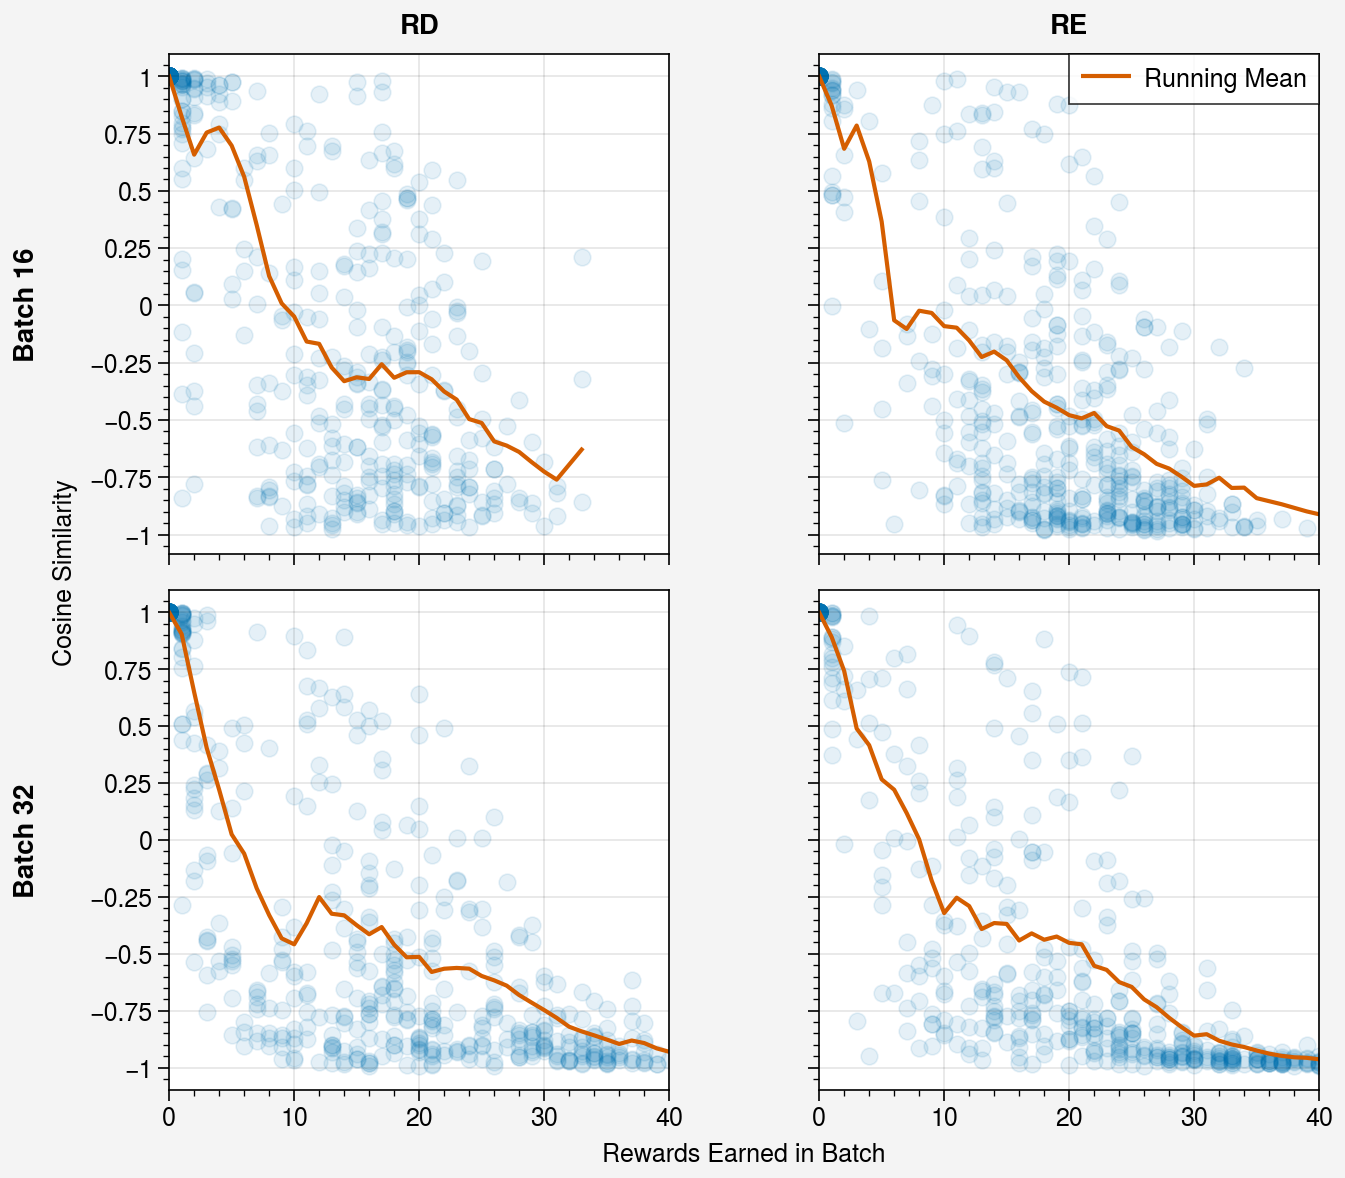

In [37]:
summary = pickle.load(open('data/grads/rew_aux_cs_summary', 'rb'))
all_cs_comb = summary['cs_comb']
all_rew = summary['rews']

aux_tasks = ['rewdistscale0015', 'rewexplore']
aux_labels = ['RD', 'RE',]

fig, ax = pplt.subplots(nrows=2, ncols=2, wspace=6)

for i, batch in enumerate(batch_sizes):
    for j, aux in enumerate(aux_tasks):
        
        cs = np.array(all_cs_comb[f'batch{batch}aux{aux}'])
        rews = np.array(all_rew[f'batch{batch}aux{aux}'])

        x_means = []
        y_means = []
        for r in np.unique(rews):
            x_means.append(r)
            y_means.append(cs[rews == r].mean())
        running_y_mean = pd.Series(y_means).ewm(alpha=0.3).mean()
        
        ax[i, j].scatter(all_rew[f'batch{batch}aux{aux}'], all_cs_comb[f'batch{batch}aux{aux}'], alpha=0.1)
        lines = [ax[i, j].plot(x_means, running_y_mean, label='Running Mean')]
        
ax.format(toplabels=aux_labels, leftlabels=[f'Batch {batch}' for batch in batch_sizes],
          xlim=[0, 40], xlabel='Rewards Earned in Batch', ylabel='Cosine Similarity')
ax[0, 1].legend(lines)

fig.savefig('plots/paper/4_2_reward_cos_sim_means')

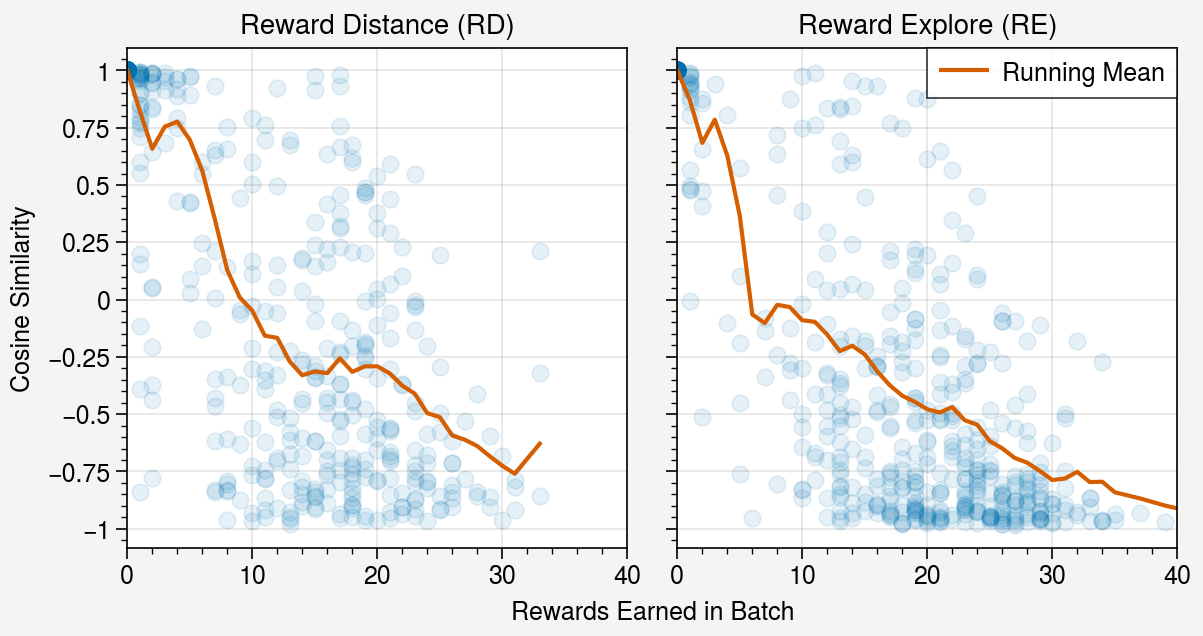

In [12]:
summary = pickle.load(open('data/grads/rew_aux_cs_summary', 'rb'))
all_cs_comb = summary['cs_comb']
all_rew = summary['rews']

aux_tasks = ['rewdistscale0015', 'rewexplore']
aux_labels = ['Reward Distance (RD)', 'Reward Explore (RE)',]

fig, ax = pplt.subplots(nrows=1, ncols=2)

batch = 16

for j, aux in enumerate(aux_tasks):

    cs = np.array(all_cs_comb[f'batch{batch}aux{aux}'])
    rews = np.array(all_rew[f'batch{batch}aux{aux}'])

    x_means = []
    y_means = []
    for r in np.unique(rews):
        x_means.append(r)
        y_means.append(cs[rews == r].mean())
    running_y_mean = pd.Series(y_means).ewm(alpha=0.3).mean()

    ax[j].scatter(all_rew[f'batch{batch}aux{aux}'], all_cs_comb[f'batch{batch}aux{aux}'], alpha=0.1)
    lines = [ax[j].plot(x_means, running_y_mean, label='Running Mean')]
        
ax.format(title=aux_labels,
          xlim=[0, 40], xlabel='Rewards Earned in Batch', ylabel='Cosine Similarity')
ax[1].legend(lines)

fig.savefig('plots/paper/4_2_reward_cos_sim_means')

# Trajectory Classification

## Example Classifications

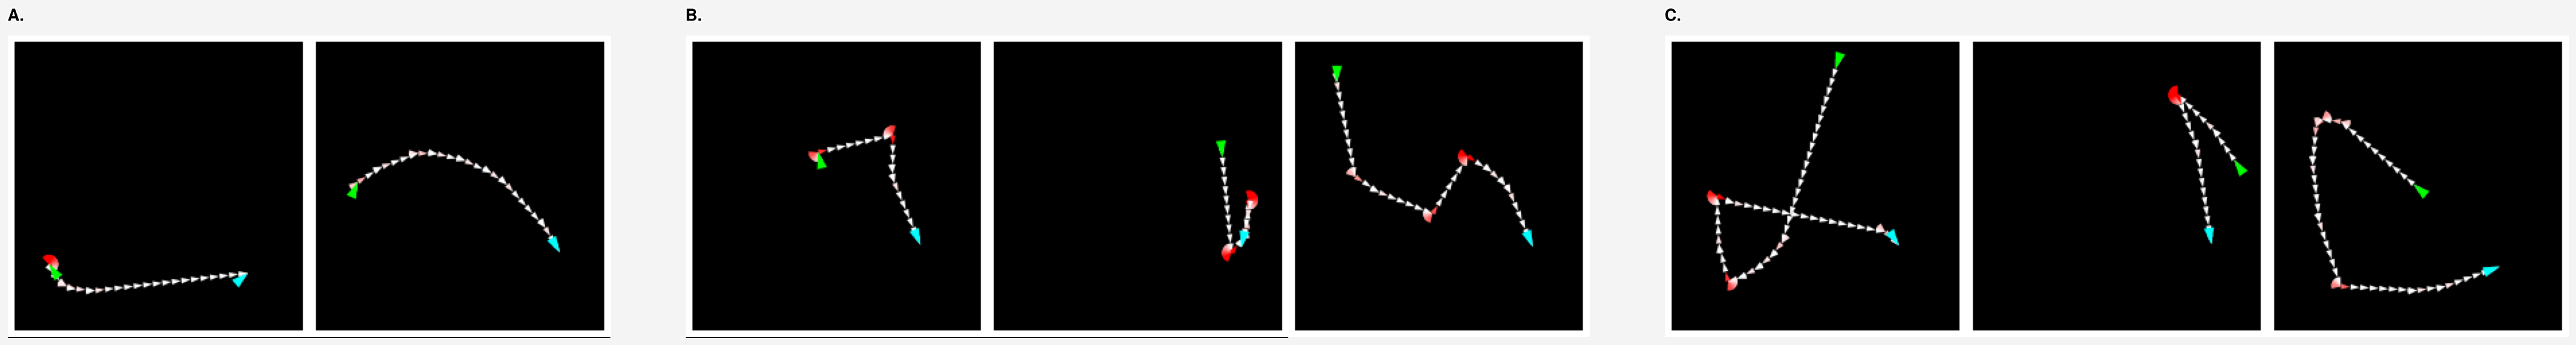

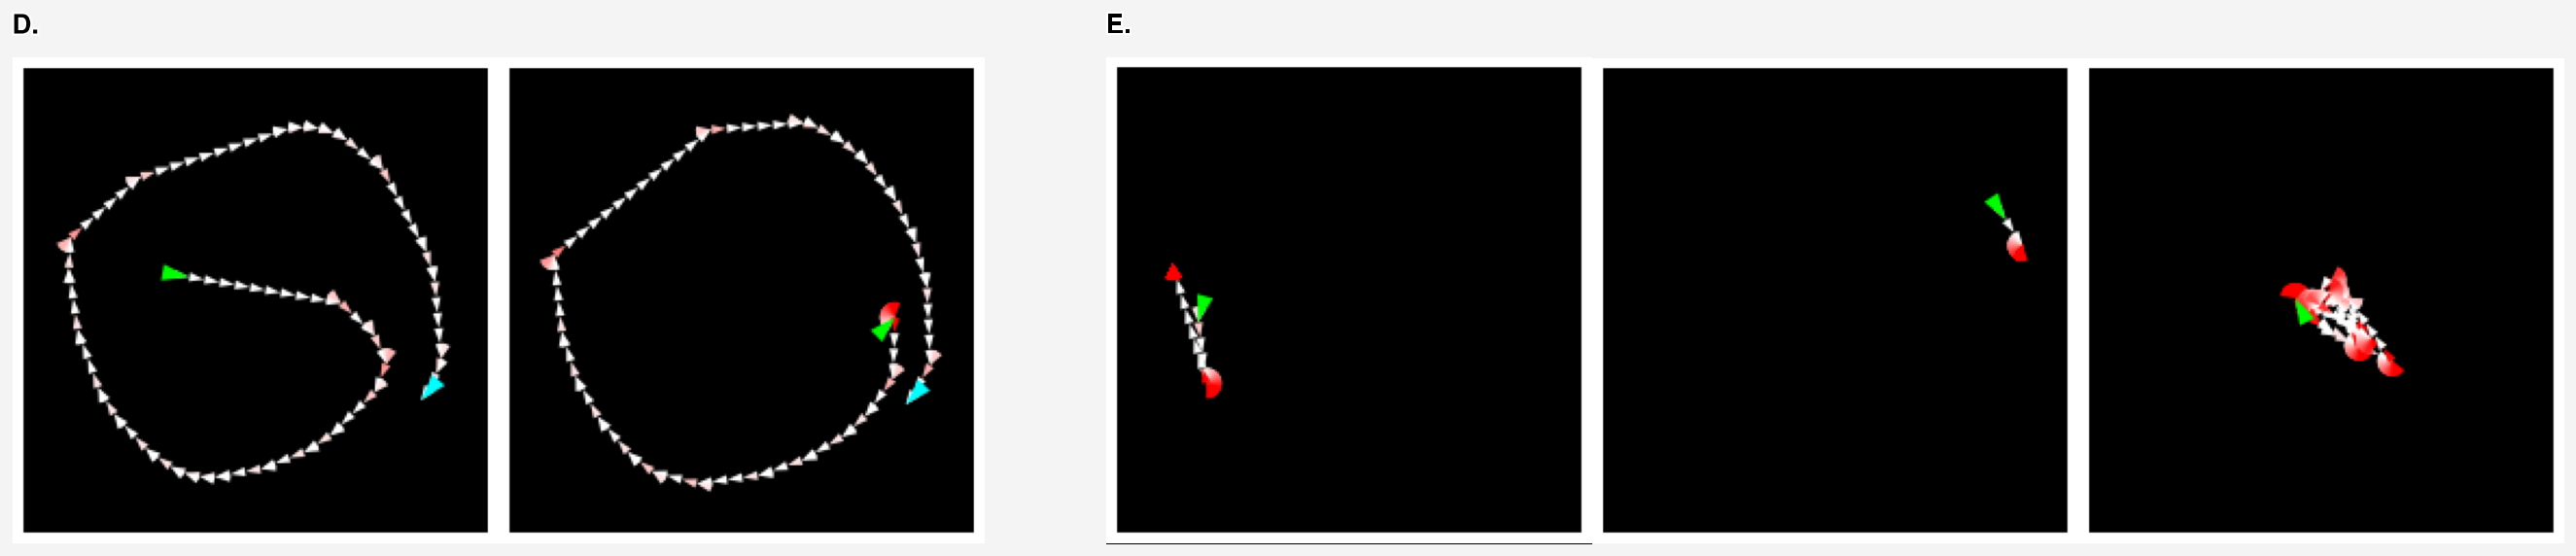

In [34]:
set_trajectory_plot_style()

traj_folder = 'data/trajectories/representative_imgs'
letters = ['A.', 'B.', 'C.', 'D.', 'E.']

traj_types = ['direct', 'uncertain_direct', 'test_corner']
num_imgs = [2, 3, 3]
fig, ax = pplt.subplots(ncols=8, wspace=(0, 5, 0, 0, 5, 0, 0))
cur_ax_idx = 0
cur_label_idx = 0
for i, typ in enumerate(traj_types):
    add_abc_to_subaxes(ax[cur_ax_idx], letters[cur_label_idx])
    cur_label_idx += 1
    for j in range(num_imgs[i]):
        img = Image.open(f'{traj_folder}/{typ}{j+1}.png')
        ax[cur_ax_idx].imshow(np.asarray(img))
        cur_ax_idx += 1
fig.savefig('plots/paper/5_1_traj_examples_1')


    
traj_types = ['circling', 'stuck']
num_imgs = [2, 3]
fig, ax = pplt.subplots(ncols=5, wspace=(0, 5, 0, 0))
cur_ax_idx = 0
for i, typ in enumerate(traj_types):
    add_abc_to_subaxes(ax[cur_ax_idx], letters[cur_label_idx])
    cur_label_idx += 1
    for j in range(num_imgs[i]):
        img = Image.open(f'{traj_folder}/{typ}{j+1}.png')
        ax[cur_ax_idx].imshow(np.asarray(img))
        cur_ax_idx += 1
fig.savefig('plots/paper/5_1_traj_examples_2')

pplt.rc.reset()

## Trajectories Over Training

In [39]:
class_res = pickle.load(open('data/trajectories/classification_results_moredata', 'rb'))

aux_tasks = ['none', 'catfacewall', 'catquad', 'catwall01', 'catwall0', 'catwall1']
aux_labels = ['Control', 'Faced Wall', 'Position Quadrant', 'Categ. East/North Wall', 'Categ. East Wall', 'Categ. North Wall']
batch_sizes = [16, 32]
all_chks = {16: [0, 50, 100, 150, 300, 600, 1000, 1500],
            32: [0, 20, 40, 80, 150, 300, 600, 900]}
trials = range(10)


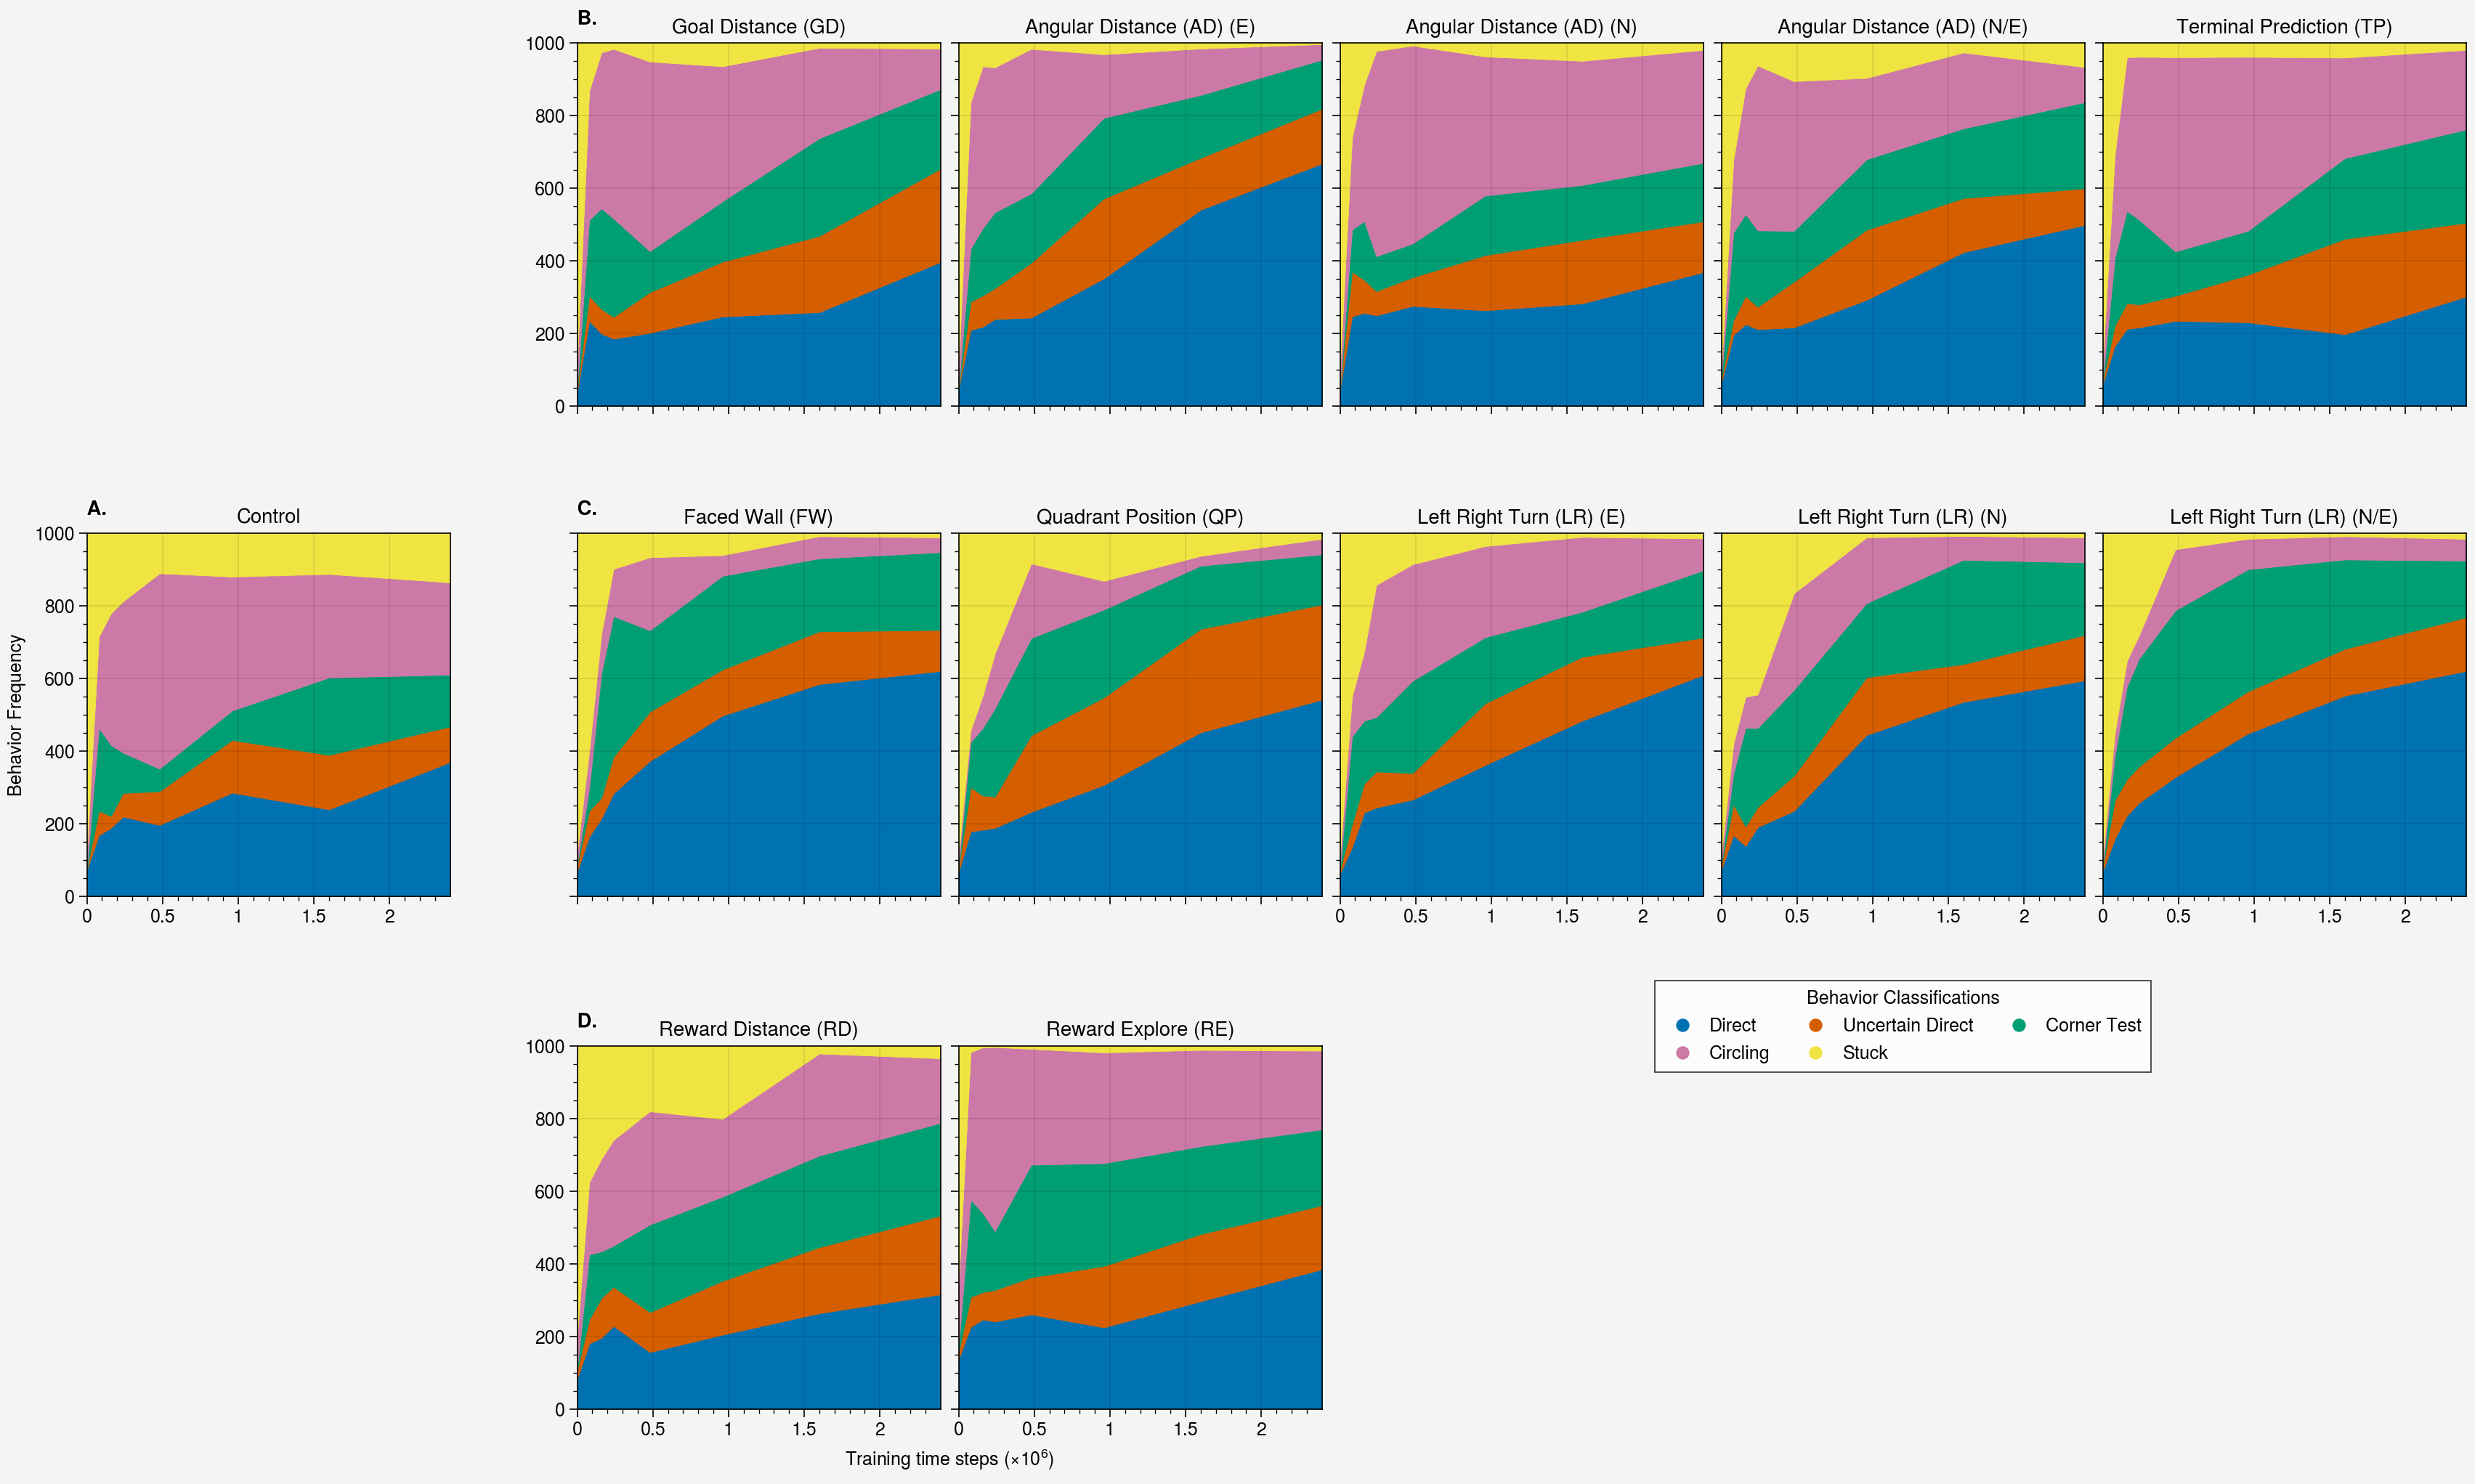

In [14]:


batch = 16
all_chks = {16: [0, 50, 100, 150, 300, 600, 1000, 1500],
            32: [0, 20, 40, 80, 150, 300, 600, 900]}
chks = all_chks[batch]
trials = range(10)

all_class_res = {
    'control': pickle.load(open('data/trajectories/cat_classification_results', 'rb')),
    'num': pickle.load(open('data/trajectories/num_classification_results', 'rb')),
    'cat': pickle.load(open('data/trajectories/cat_classification_results', 'rb')), #control is part of this
    'rew': pickle.load(open('data/trajectories/rew_classification_results', 'rb'))
}

all_aux_tasks = {
    'control': ['none'],
    'num': ['goaldist', 'wall0', 'wall1', 'wall01', 'terminal'],
    'cat': ['catfacewall', 'catquad', 'catwall0', 'catwall1', 'catwall01'],
    'rew': ['rewdistscale0015', 'rewexplore']
}

all_aux_labels = {
    'control': ['Control'],
    # 'num': ['GD', 'AD (E)', 'AD (N)', 'AD (N/E)', 'TP'],
    'num': ['Goal Distance (GD)', 'Angular Distance (AD) (E)', 
              'Angular Distance (AD) (N)', 'Angular Distance (AD) (N/E)', 
              'Terminal Prediction (TP)'],
    # 'cat': ['FW', 'QP', 'LR (E)', 'LR (N)', 'LR (E/N)']
    'cat': ['Faced Wall (FW)', 'Quadrant Position (QP)', 
              'Left Right Turn (LR) (E)', 'Left Right Turn (LR) (N)', 'Left Right Turn (LR) (N/E)'],
    'rew': ['Reward Distance (RD)', 'Reward Explore (RE)'],
}

aranged_vocab = { #ordering labels and their corresponding idx by importance
    1: 'direct',
    4: 'uncertain_direct',
    3: 'test_corner',
    0: 'circling',
    2: 'stuck'
}
behavior_labels = ['Direct', 'Uncertain Direct', 'Corner Test', 'Circling', 'Stuck']

array = [
    [0, 2, 3, 4, 5, 6],
    [1, 7, 8, 9, 10, 11],
    [0, 12, 13, 0, 0, 0],
]
fig, ax = pplt.subplots(array, wspace=(7, 1, 1, 1, 1), hspace=(7, 2))

aux_types = ['control', 'num', 'cat', 'rew']
titles = []
cur_ax_idx = 0
for typ in aux_types:
    aux_tasks = all_aux_tasks[typ]
    aux_labels = all_aux_labels[typ]
    class_res = all_class_res[typ]
    for j, aux in enumerate(aux_tasks):
        xs = []
        ys = [[] for i in range(len(aranged_vocab))]
        for chk in chks:
            xs.append(chk * 100 * batch / 1000000)

            counts = [0 for i in range(len(aranged_vocab))]
            for trial in trials:
                res = class_res[batch][aux][trial][chk]

                #Count up amount of each label
                y = np.array([idx for idx in res['idxs']])
                for n, idx in enumerate(aranged_vocab):
                    counts[n] += (y == idx).sum()

            for n in range(len(counts)):
                ys[n].append(counts[n])

                
        ax[cur_ax_idx].stackplot(xs, *ys)
        titles.append(aux_labels[j])
        cur_ax_idx += 1

rgb_colors = color_cycle('colorblind')
ls = []
for n, label in enumerate(aranged_vocab.values()):
     ls.append(ax[0].scatter([0], [-100], label=behavior_labels[n], c=rgb_colors[n]))
        
ax.format(title=titles, ylim=[0, 1000])
ax[0].format(ylabel='Behavior Frequency')
ax[11:].format(xlabel=r'Training time steps ($\times 10^6$)')

ax[9].legend(ls, loc='b', ncols=3, pad=3, title='Behavior Classifications')

add_abc_to_subaxes(ax[0], 'A.')
add_abc_to_subaxes(ax[1], 'B.')
add_abc_to_subaxes(ax[6], 'C.')
add_abc_to_subaxes(ax[11], 'D.')

fig.savefig('plots/paper/5_2_trajectories_during_training')

## Strategy Usage vs. Performance

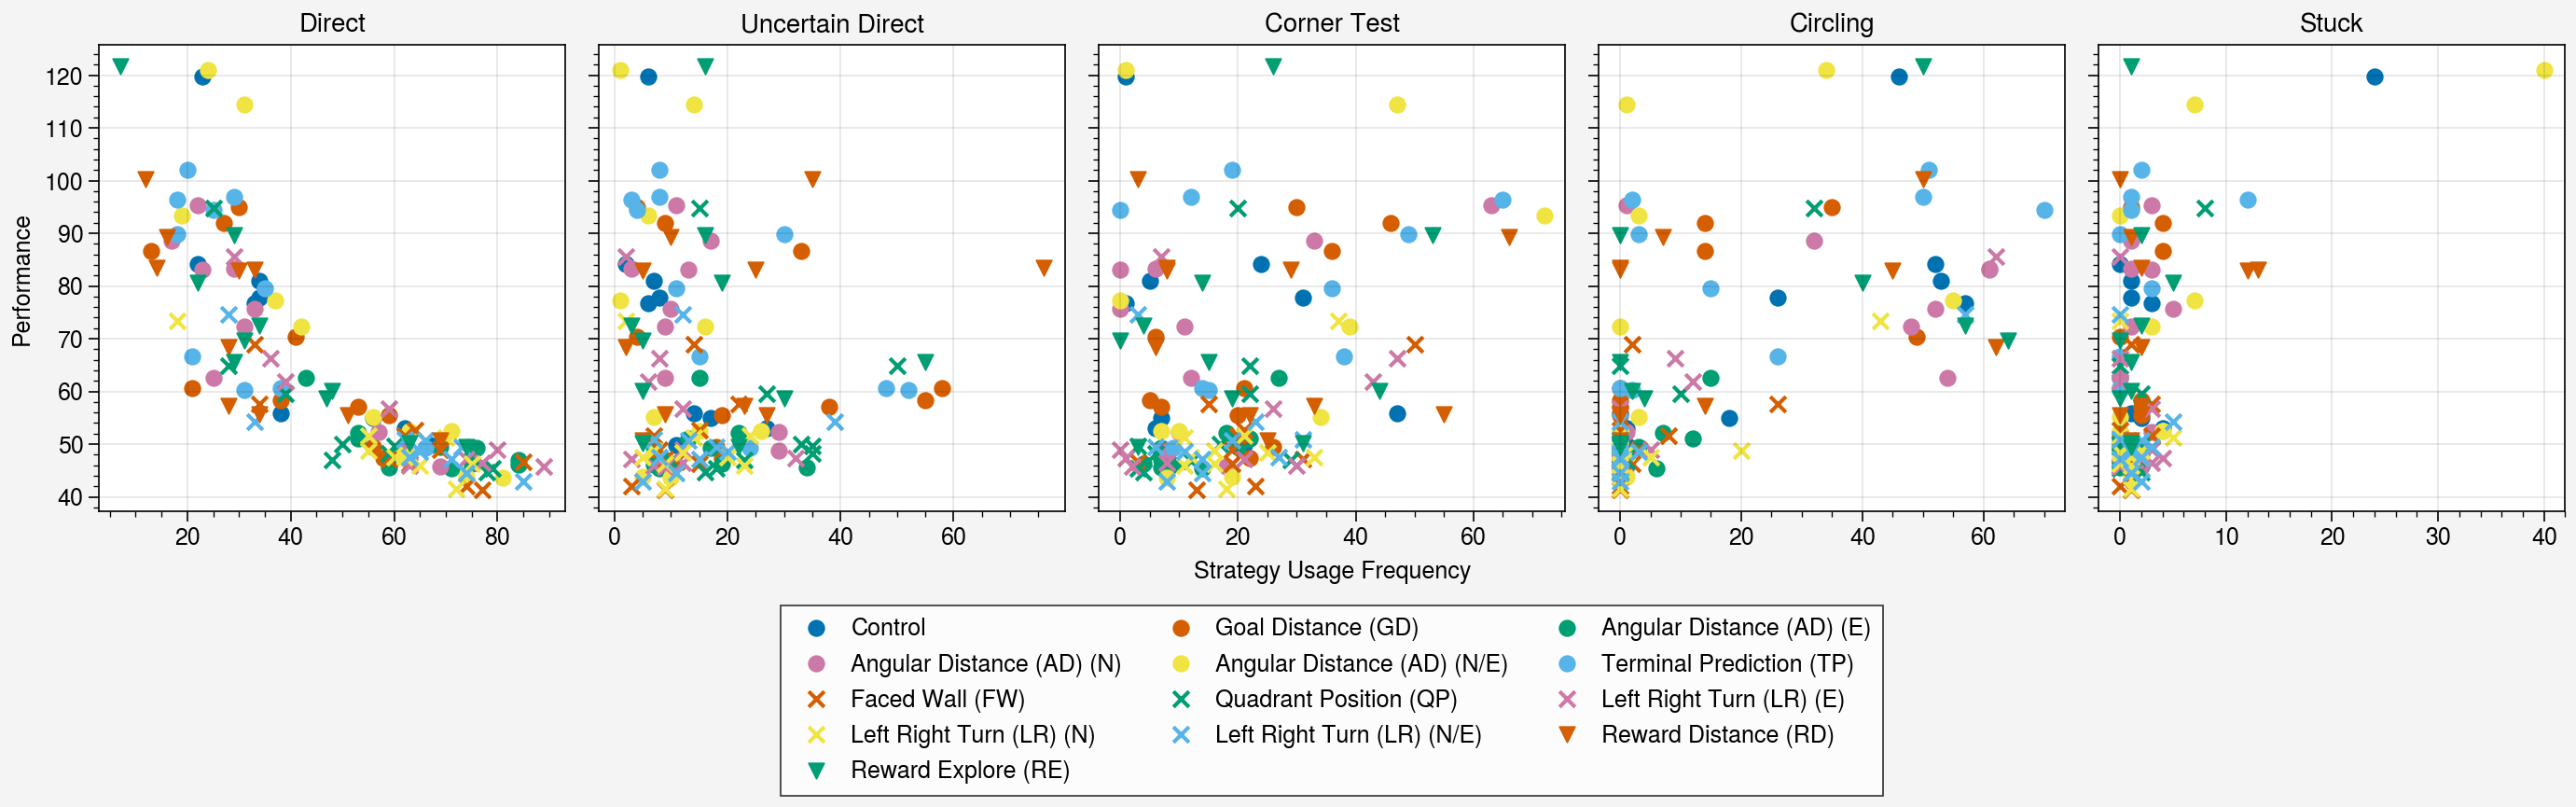

In [44]:

batch = 16
all_chks = {16: [0, 50, 100, 150, 300, 600, 1000, 1500],
            32: [0, 20, 40, 80, 150, 300, 600, 900]}
chks = all_chks[batch]
trials = range(10)

all_class_res = {
    'control': pickle.load(open('data/trajectories/cat_classification_results', 'rb')),
    'num': pickle.load(open('data/trajectories/num_classification_results', 'rb')),
    'cat': pickle.load(open('data/trajectories/cat_classification_results', 'rb')), #control is part of this
    'rew': pickle.load(open('data/trajectories/rew_classification_results', 'rb'))
}

all_exp_formats = {
    'control': 'nav_pdistal_batchaux/nav_pdistal_batch{}aux{}',
    'num': 'nav_pdistal_batchauxcoef1/nav_pdistal_batch{}aux{}coef1',
    'cat': 'nav_pdistal_auxcatcoef1/nav_pdistal_batch{}aux{}coef1',
    'rew': 'nav_pdistal_batchaux/nav_pdistal_batch{}aux{}'
}

all_aux_tasks = {
    'control': ['none'],
    'num': ['goaldist', 'wall0', 'wall1', 'wall01', 'terminal'],
    'cat': ['catfacewall', 'catquad', 'catwall0', 'catwall1', 'catwall01'],
    'rew': ['rewdistscale0015', 'rewexplore']
}

all_aux_labels = {
    'control': ['Control'],
    # 'num': ['GD', 'AD (E)', 'AD (N)', 'AD (N/E)', 'TP'],
    'num': ['Goal Distance (GD)', 'Angular Distance (AD) (E)', 
              'Angular Distance (AD) (N)', 'Angular Distance (AD) (N/E)', 
              'Terminal Prediction (TP)'],
    # 'cat': ['FW', 'QP', 'LR (E)', 'LR (N)', 'LR (E/N)']
    'cat': ['Faced Wall (FW)', 'Quadrant Position (QP)', 
              'Left Right Turn (LR) (E)', 'Left Right Turn (LR) (N)', 'Left Right Turn (LR) (N/E)'],
    'rew': ['Reward Distance (RD)', 'Reward Explore (RE)'],
}

all_scatter_markers = {
    'control': None,
    'num': None,
    'cat': 'x',
    'rew': 'v'
}

aranged_vocab = { #ordering labels and their corresponding idx by importance
    1: 'direct',
    4: 'uncertain_direct',
    3: 'test_corner',
    0: 'circling',
    2: 'stuck'
}
behavior_labels = ['Direct', 'Uncertain Direct', 'Corner Test', 'Circling', 'Stuck']
aux_types = ['control', 'num', 'cat', 'rew']

chk = 1500
timepoint = chk*16*100

# fig, ax = pplt.subplots(ncols=len(behavior_labels)+1)
fig, ax = pplt.subplots(ncols=len(behavior_labels))

scatters = []
for typ in aux_types:
    aux_tasks = all_aux_tasks[typ]
    aux_labels = all_aux_labels[typ]
    for n, aux in enumerate(aux_tasks):
        exp_format = all_exp_formats[typ]
        exp_name = exp_format.format(batch, aux)
        class_res = all_class_res[typ]
        scatter_marker = all_scatter_markers[typ]
        
        xs, ys, start_x, start_y = average_runs(exp_name, 'length', ignore_first=100, ewm=0.001, ret=True)
        idx = np.argwhere(xs > timepoint)[0][0]
        y_timepoint = list(ys[:, idx])
        
        if aux == 'none':
            del y_timepoint[6]
        
        xs = defaultdict(list)
        for trial in trials:
            # Remove outlier in control that has all stuck behavior
            if aux == 'none' and trial == 6:
                continue
            idxs = class_res[batch][aux][trial][chk]['idxs']

            spatial_usage = (idxs == 1).sum() + (idxs == 4).sum() + (idxs == 3).sum()

            # xs['spatial'].append(spatial_usage)
            xs['direct'].append((idxs == 1).sum())
            xs['uncertain_direct'].append((idxs == 4).sum())
            xs['test_corner'].append((idxs == 3).sum())
            xs['circling'].append((idxs == 0).sum())
            xs['stuck'].append((idxs == 2).sum())
            
            
            
        for j, key in enumerate(xs):
            if aux == 'none':
                c = rgb_colors[0]
            else:
                c = rgb_colors[n+1]
            scatter = ax[j].scatter(xs[key], y_timepoint, marker=scatter_marker,
                                       c=c, label=aux_labels[n])
            
            if j == 0:
                scatters.append(scatter)
        
ax.format(title=behavior_labels, xlabel='Strategy Usage Frequency',
          ylabel='Performance')
fig.legend(scatters, loc='b')

fig.savefig('plots/paper/5_3_strategy_vs_performance_chk1500')

**De-identified scatter plot for easier reading, includes all auxiliary tasks**

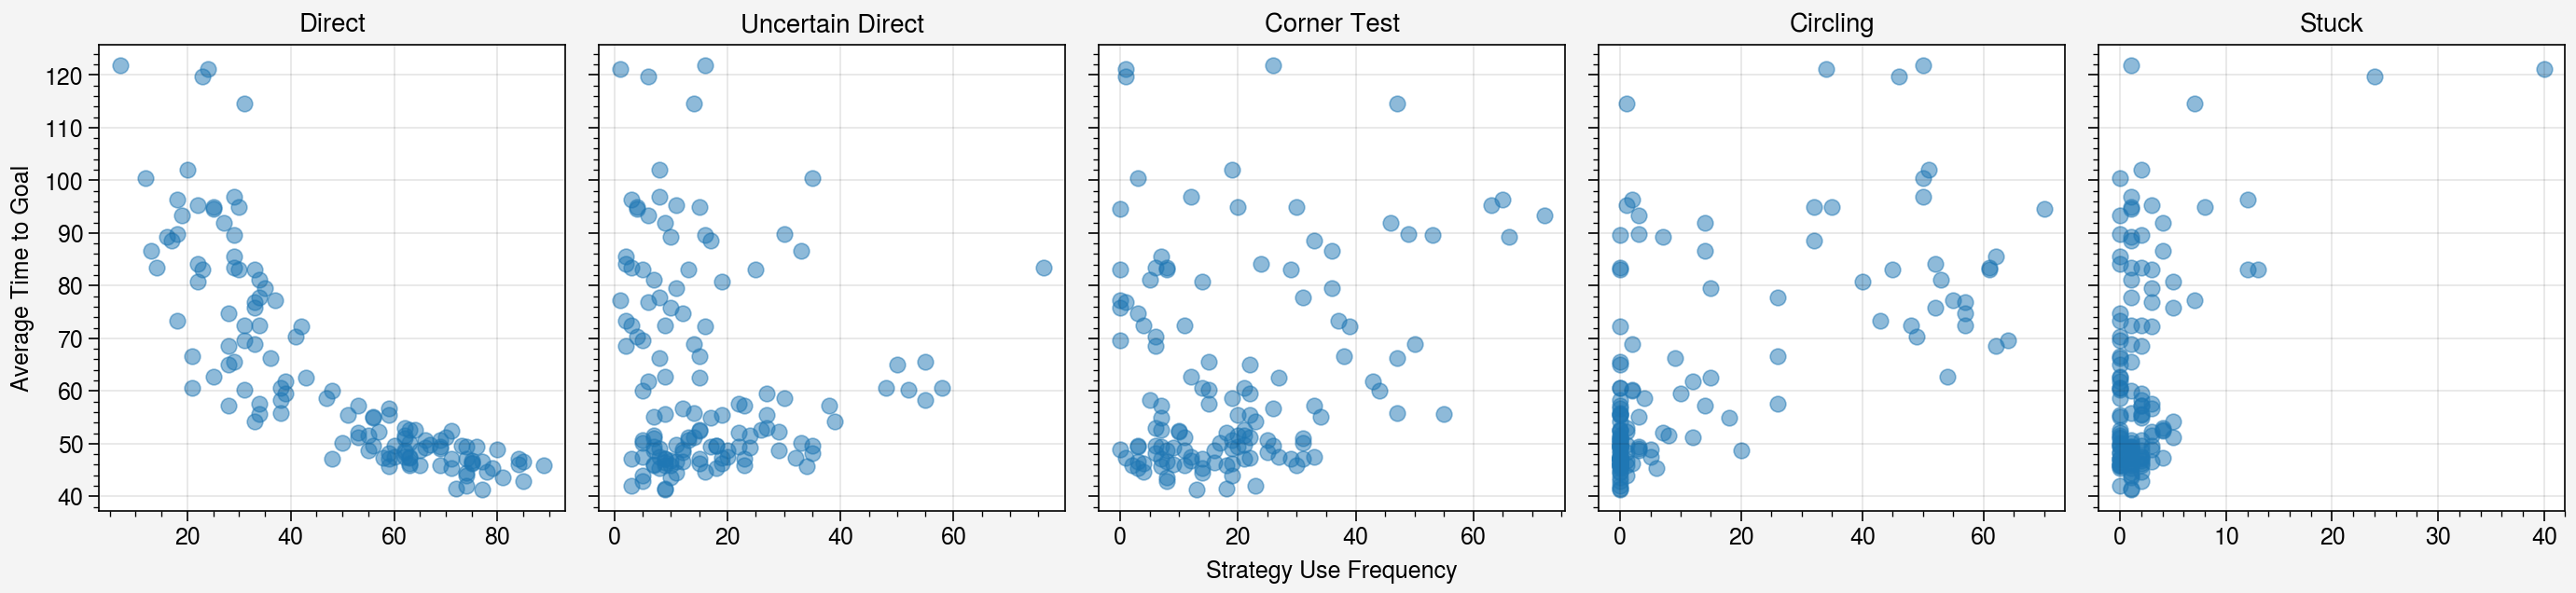

In [4]:

batch = 16
all_chks = {16: [0, 50, 100, 150, 300, 600, 1000, 1500],
            32: [0, 20, 40, 80, 150, 300, 600, 900]}
chks = all_chks[batch]
trials = range(10)

all_class_res = {
    'control': pickle.load(open('data/trajectories/cat_classification_results', 'rb')),
    'num': pickle.load(open('data/trajectories/num_classification_results', 'rb')),
    'cat': pickle.load(open('data/trajectories/cat_classification_results', 'rb')), #control is part of this
    'rew': pickle.load(open('data/trajectories/rew_classification_results', 'rb'))
}

all_exp_formats = {
    'control': 'nav_pdistal_batchaux/nav_pdistal_batch{}aux{}',
    'num': 'nav_pdistal_batchauxcoef1/nav_pdistal_batch{}aux{}coef1',
    'cat': 'nav_pdistal_auxcatcoef1/nav_pdistal_batch{}aux{}coef1',
    'rew': 'nav_pdistal_batchaux/nav_pdistal_batch{}aux{}'
}

all_aux_tasks = {
    'control': ['none'],
    'num': ['goaldist', 'wall0', 'wall1', 'wall01', 'terminal'],
    'cat': ['catfacewall', 'catquad', 'catwall0', 'catwall1', 'catwall01'],
    'rew': ['rewdistscale0015', 'rewexplore']
}

all_aux_labels = {
    'control': ['Control'],
    # 'num': ['GD', 'AD (E)', 'AD (N)', 'AD (N/E)', 'TP'],
    'num': ['Goal Distance (GD)', 'Angular Distance (AD) (E)', 
              'Angular Distance (AD) (N)', 'Angular Distance (AD) (N/E)', 
              'Terminal Prediction (TP)'],
    # 'cat': ['FW', 'QP', 'LR (E)', 'LR (N)', 'LR (E/N)']
    'cat': ['Faced Wall (FW)', 'Quadrant Position (QP)', 
              'Left Right Turn (LR) (E)', 'Left Right Turn (LR) (N)', 'Left Right Turn (LR) (N/E)'],
    'rew': ['Reward Distance (RD)', 'Reward Explore (RE)'],
}

all_scatter_markers = {
    'control': None,
    'num': None,
    'cat': 'x',
    'rew': 'v'
}

aranged_vocab = { #ordering labels and their corresponding idx by importance
    1: 'direct',
    4: 'uncertain_direct',
    3: 'test_corner',
    0: 'circling',
    2: 'stuck'
}
behavior_labels = ['Direct', 'Uncertain Direct', 'Corner Test', 'Circling', 'Stuck']
aux_types = ['control', 'num', 'cat', 'rew']

chk = 1500
timepoint = chk*16*100

# fig, ax = pplt.subplots(ncols=len(behavior_labels)+1)
fig, ax = pplt.subplots(ncols=len(behavior_labels))

scatters = []
for typ in aux_types:
    aux_tasks = all_aux_tasks[typ]
    aux_labels = all_aux_labels[typ]
    for n, aux in enumerate(aux_tasks):
        exp_format = all_exp_formats[typ]
        exp_name = exp_format.format(batch, aux)
        class_res = all_class_res[typ]
        scatter_marker = all_scatter_markers[typ]
        
        xs, ys, start_x, start_y = average_runs(exp_name, 'length', ignore_first=100, ewm=0.001, ret=True)
        idx = np.argwhere(xs > timepoint)[0][0]
        y_timepoint = list(ys[:, idx])
        
        if aux == 'none':
            del y_timepoint[6]
        
        xs = defaultdict(list)
        for trial in trials:
            # Remove outlier in control that has all stuck behavior
            if aux == 'none' and trial == 6:
                continue
            idxs = class_res[batch][aux][trial][chk]['idxs']

            spatial_usage = (idxs == 1).sum() + (idxs == 4).sum() + (idxs == 3).sum()

            # xs['spatial'].append(spatial_usage)
            xs['direct'].append((idxs == 1).sum())
            xs['uncertain_direct'].append((idxs == 4).sum())
            xs['test_corner'].append((idxs == 3).sum())
            xs['circling'].append((idxs == 0).sum())
            xs['stuck'].append((idxs == 2).sum())
            
            
            
        for j, key in enumerate(xs):
            scatter = ax[j].scatter(xs[key], y_timepoint,
                                       c=rgb_colors[0], label=aux_labels[n], alpha=0.5)
            
            if j == 0:
                scatters.append(scatter)
        
ax.format(title=behavior_labels, xlabel='Strategy Use Frequency',
          ylabel='Average Time to Goal')

fig.savefig('plots/paper/5_3_strategy_vs_performance_chk1500')

## Optimal Agent Strategies

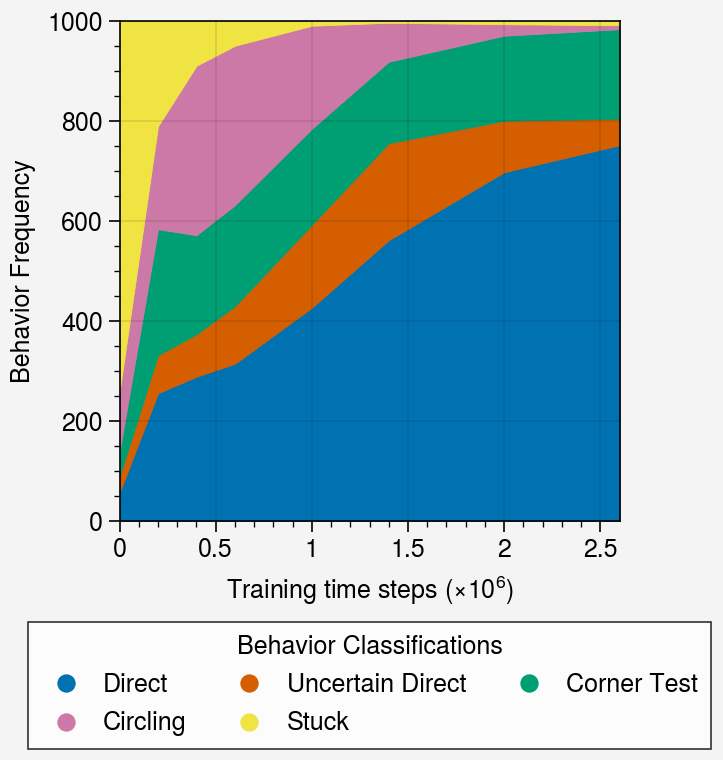

In [5]:


chks = all_chks[batch]
trials = range(10)
chks = [0, 10, 20, 30, 50, 70, 100, 130]

class_res = pickle.load(open('data/trajectories/width64_classification_results', 'rb'))


aranged_vocab = { #ordering labels and their corresponding idx by importance
    1: 'direct',
    4: 'uncertain_direct',
    3: 'test_corner',
    0: 'circling',
    2: 'stuck'
}
behavior_labels = ['Direct', 'Uncertain Direct', 'Corner Test', 'Circling', 'Stuck']

fig, ax = pplt.subplots()

xs = []
ys = [[] for i in range(len(aranged_vocab))]
for chk in chks:
    xs.append(chk * 100 * 200 / 1000000)

    counts = [0 for i in range(len(aranged_vocab))]
    for trial in trials:
        res = class_res[trial][chk]

        #Count up amount of each label
        y = np.array([idx for idx in res['idxs']])
        for n, idx in enumerate(aranged_vocab):
            counts[n] += (y == idx).sum()

    for n in range(len(counts)):
        ys[n].append(counts[n])

ax.stackplot(xs, *ys)

rgb_colors = color_cycle('colorblind')
ls = []
for n, label in enumerate(aranged_vocab.values()):
     ls.append(ax.scatter([0], [-100], label=behavior_labels[n], c=rgb_colors[n]))

ax.format(ylim=[0, 1000], ylabel='Behavior Frequency', 
          xlabel=r'Training time steps ($\times 10^6$)')

fig.legend(ls, loc='b', ncols=3, title='Behavior Classifications')

fig.savefig('plots/paper/5_4_64width_strategies')